In [ ]:
import datetime
import numpy as np
import pandas as pd
import glob
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from google.colab import drive
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

drive.mount("drive")
drive.mount('/content/gdrive')

def calculate_MAPE(predicted, truth):
    predicted = np.array(predicted)
    truth = np.array(truth)
    ape = np.abs(predicted - truth) / np.abs(truth)
    mape = np.mean(ape) * 100
    return mape

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at drive
Mounted at /content/gdrive


# np.polyfit

In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/CS145-COVID-master.zip (Unzipped Files)/CS145-COVID-master/cleaned_train.csv")
test = pd.read_csv("/content/gdrive/MyDrive/CS145-COVID-master.zip (Unzipped Files)/CS145-COVID-master/cleaned_test.csv")
submit_csv = pd.read_csv("/content/gdrive/MyDrive/COVID19_project/test.csv")
submit_csv.head()

,ForecastID,Province_State,Date,Confirmed,Deaths
0,0,Alabama,09-01-2020,-1,-1
1,1,Alaska,09-01-2020,-1,-1
2,2,Arizona,09-01-2020,-1,-1
3,3,Arkansas,09-01-2020,-1,-1
4,4,California,09-01-2020,-1,-1


In [ ]:
test['Last_Update'].unique()

array(['2020-09-01 04:30:22', '2020-09-02 04:30:23',
       '2020-09-03 04:30:31', '2020-09-04 04:30:31',
       '2020-09-05 04:30:29', '2020-09-06 04:30:30',
       '2020-09-07 04:30:33', '2020-09-08 04:30:25',
       '2020-09-09 04:30:32', '2020-09-10 04:30:24',
       '2020-09-11 04:30:23', '2020-09-12 04:30:24',
       '2020-09-13 04:32:00', '2020-09-14 04:30:37',
       '2020-09-15 03:30:30', '2020-09-16 04:30:32',
       '2020-09-17 04:30:32', '2020-09-18 05:10:31',
       '2020-09-19 04:30:26', '2020-09-20 04:30:31',
       '2020-09-21 04:30:33', '2020-09-22 04:30:33',
       '2020-09-23 04:30:25', '2020-09-24 04:30:25',
       '2020-09-25 04:30:27', '2020-09-26 04:30:24'], dtype=object)

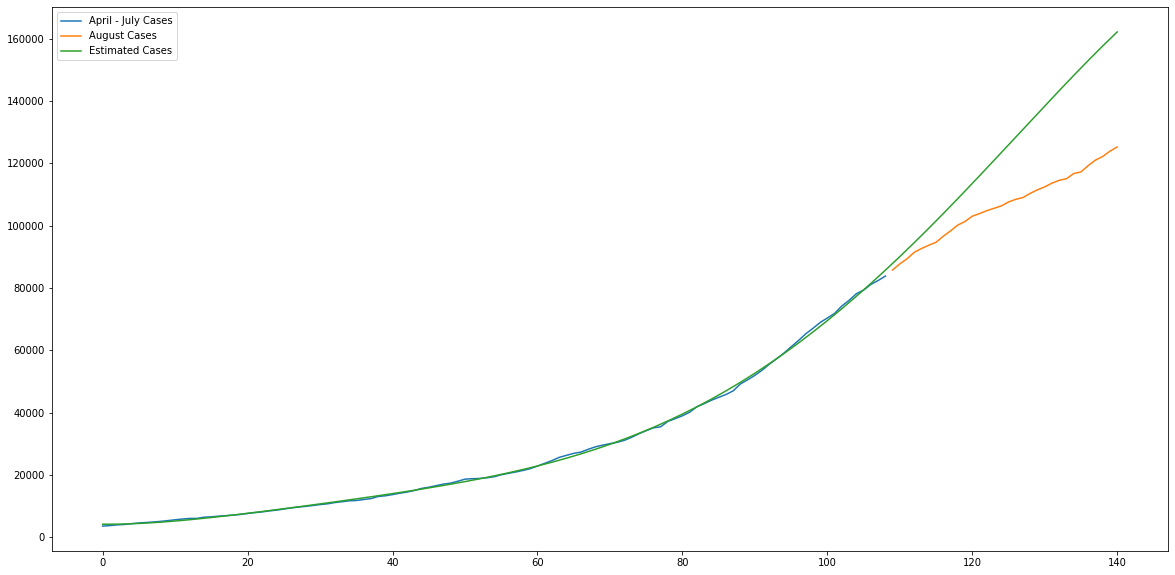

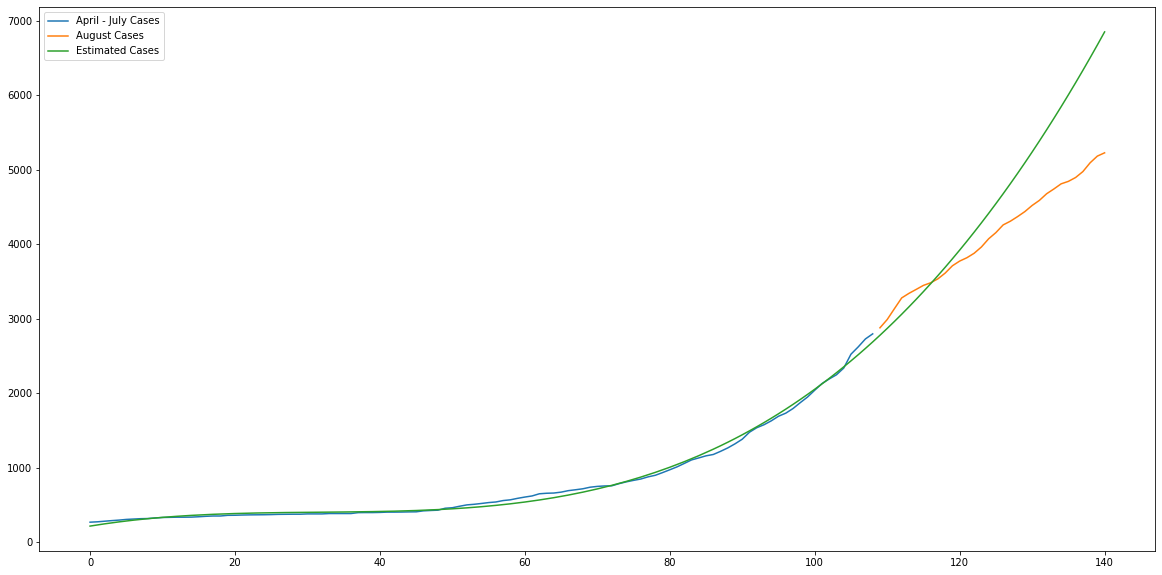

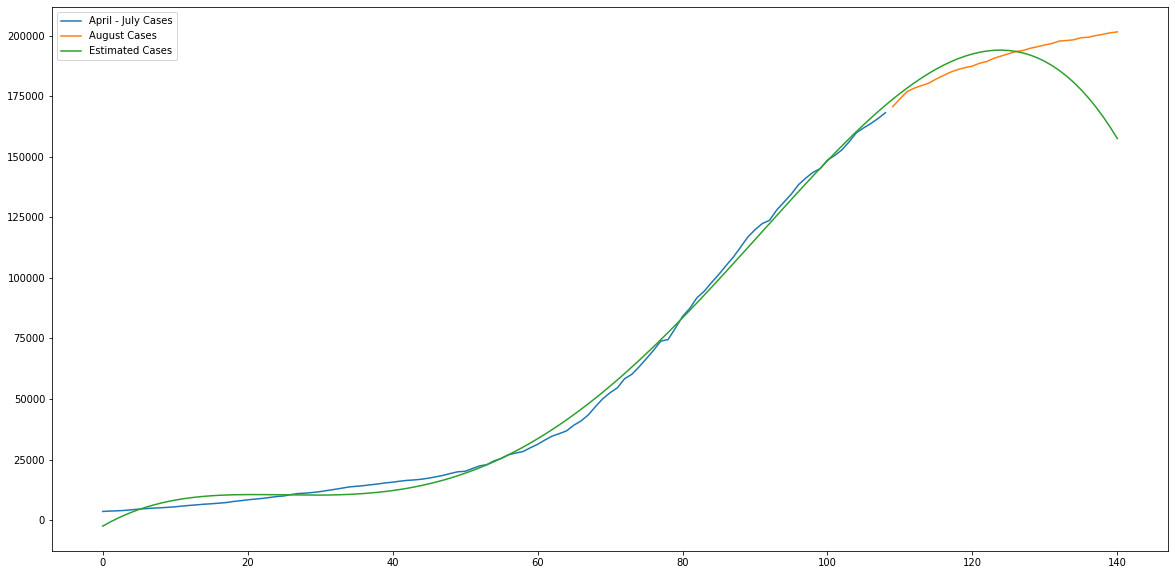

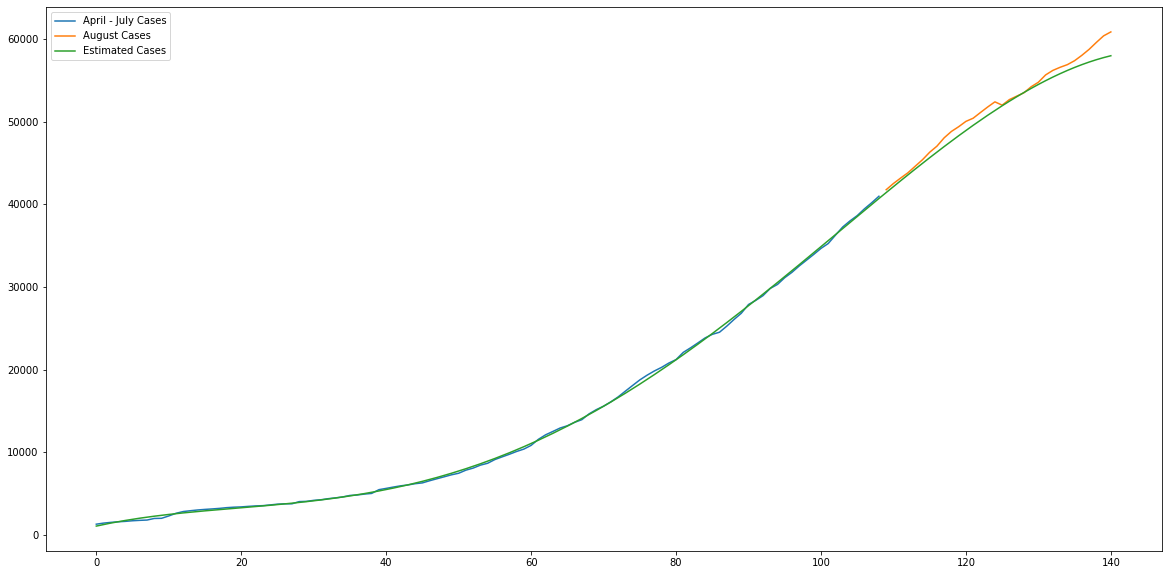

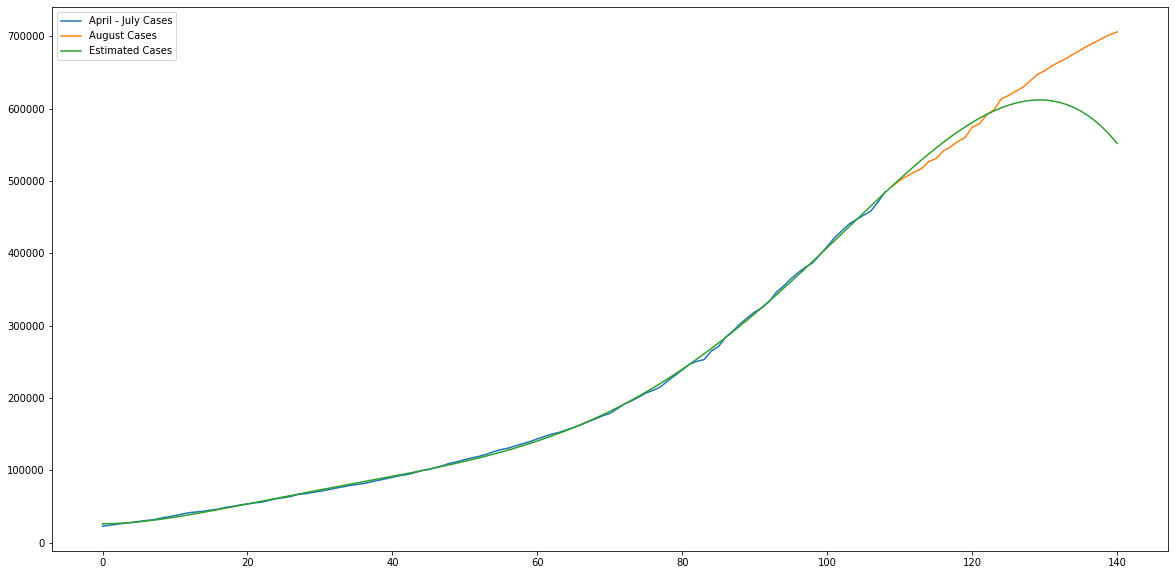

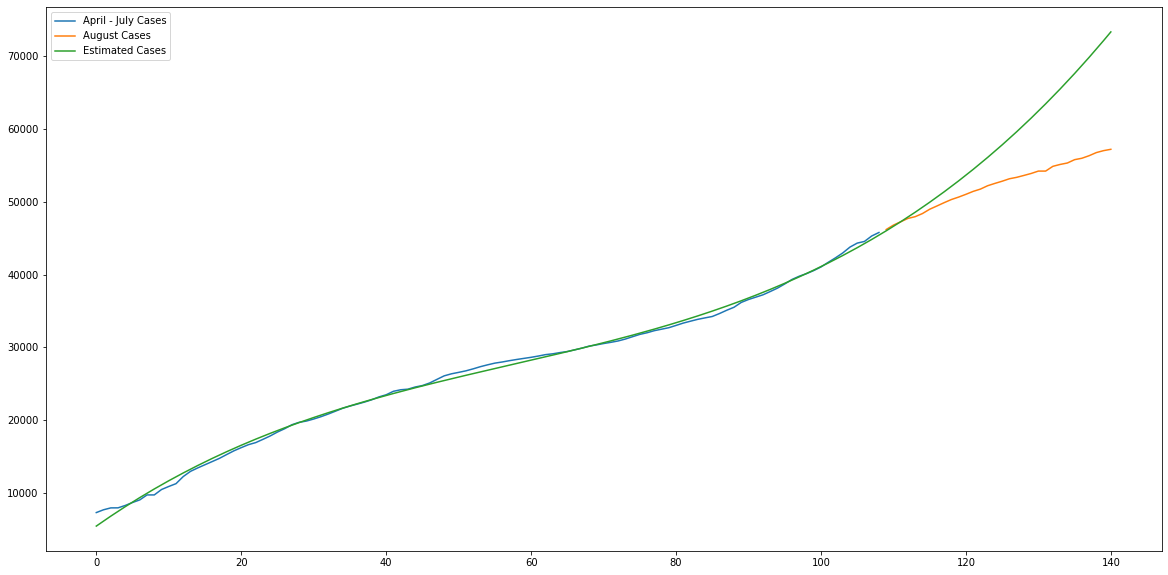

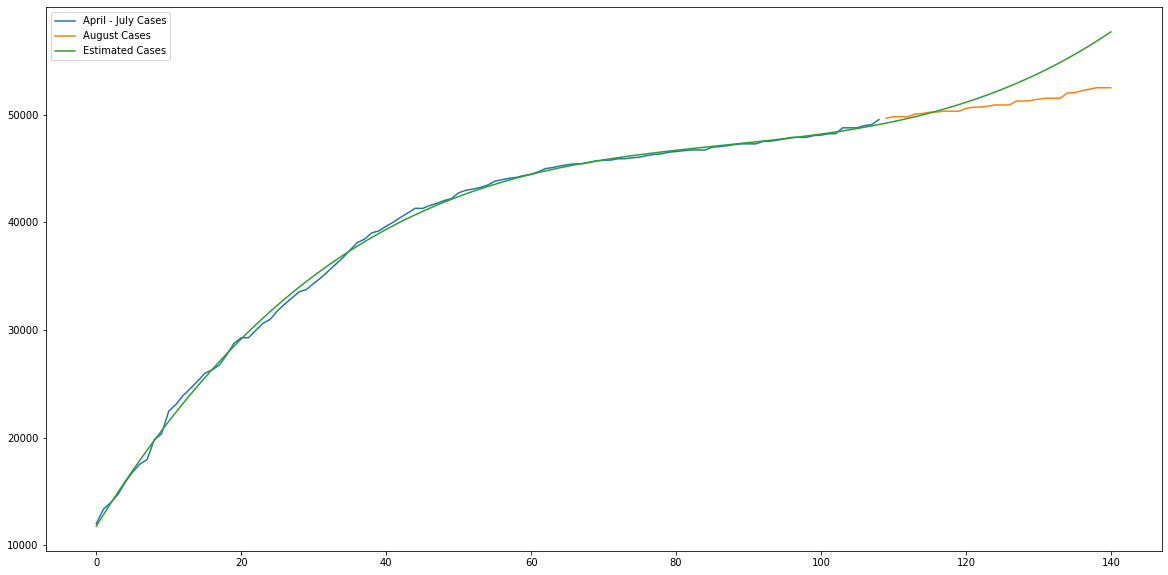

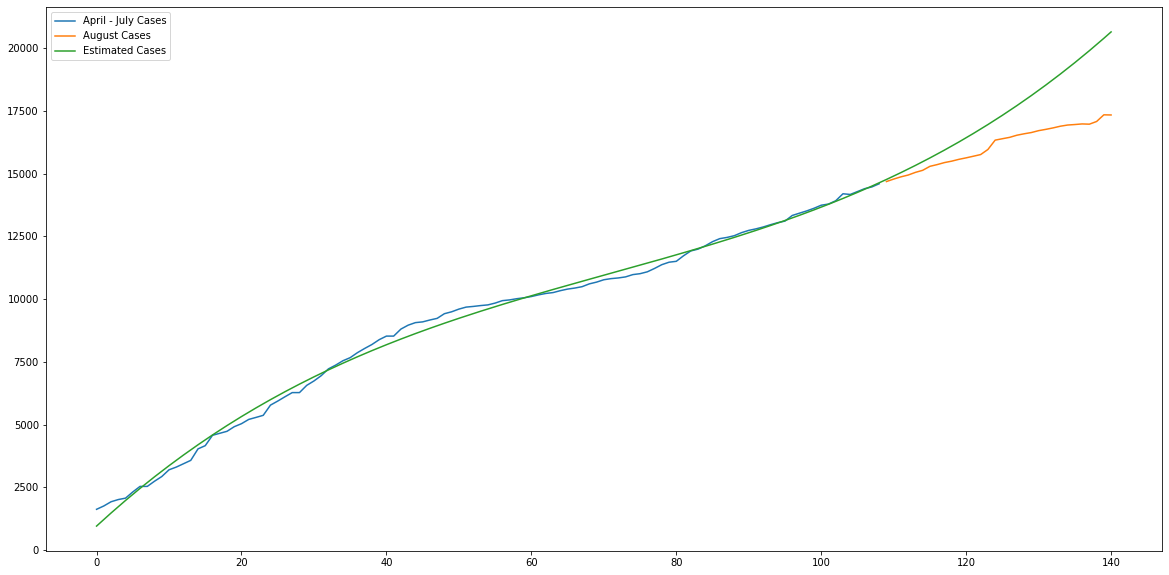

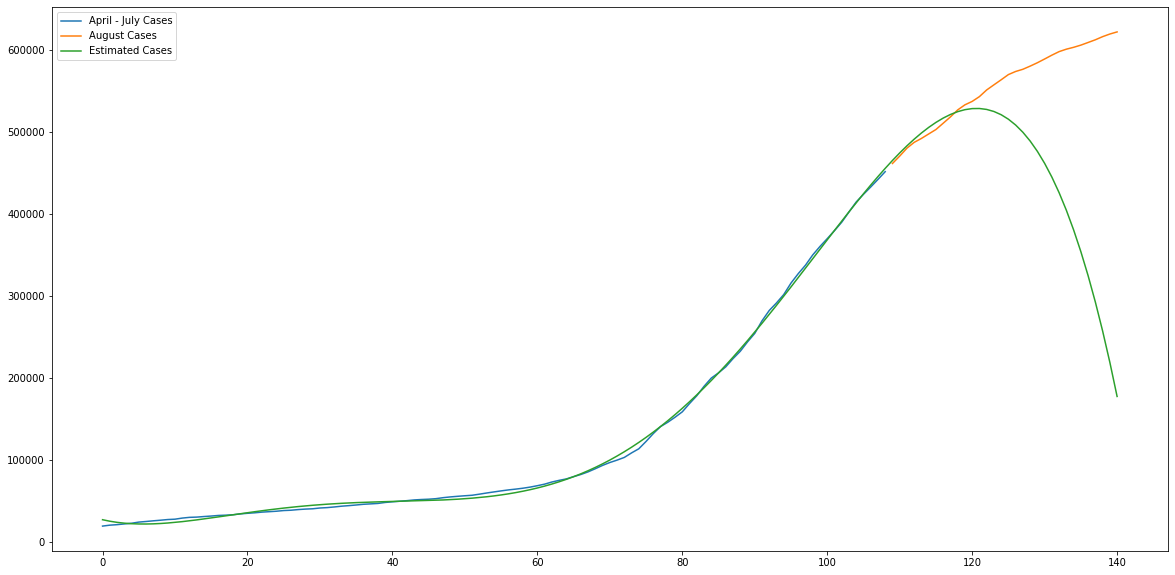

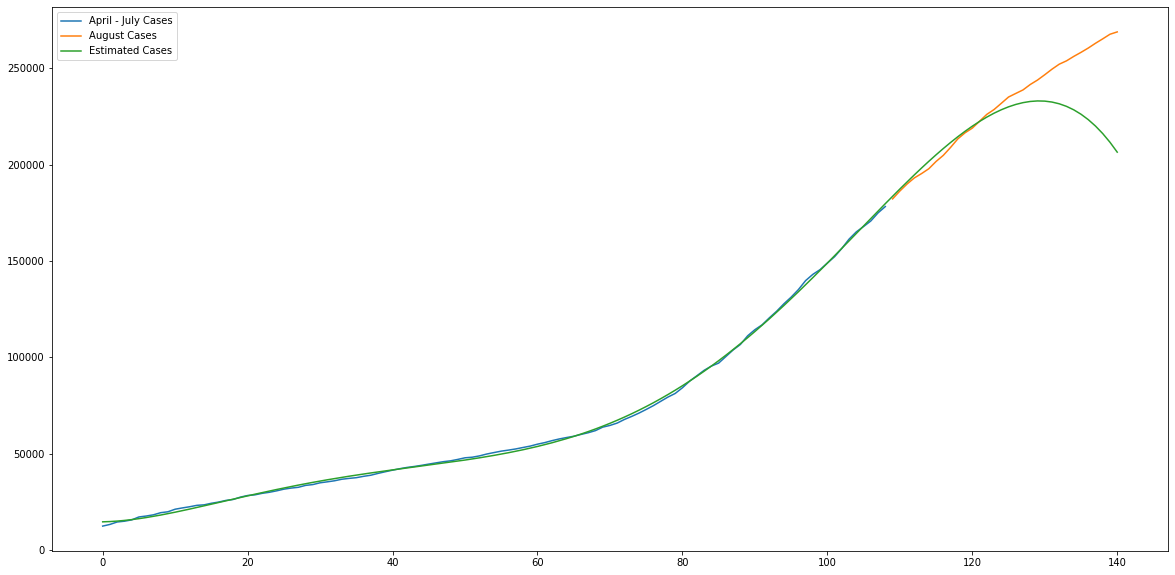

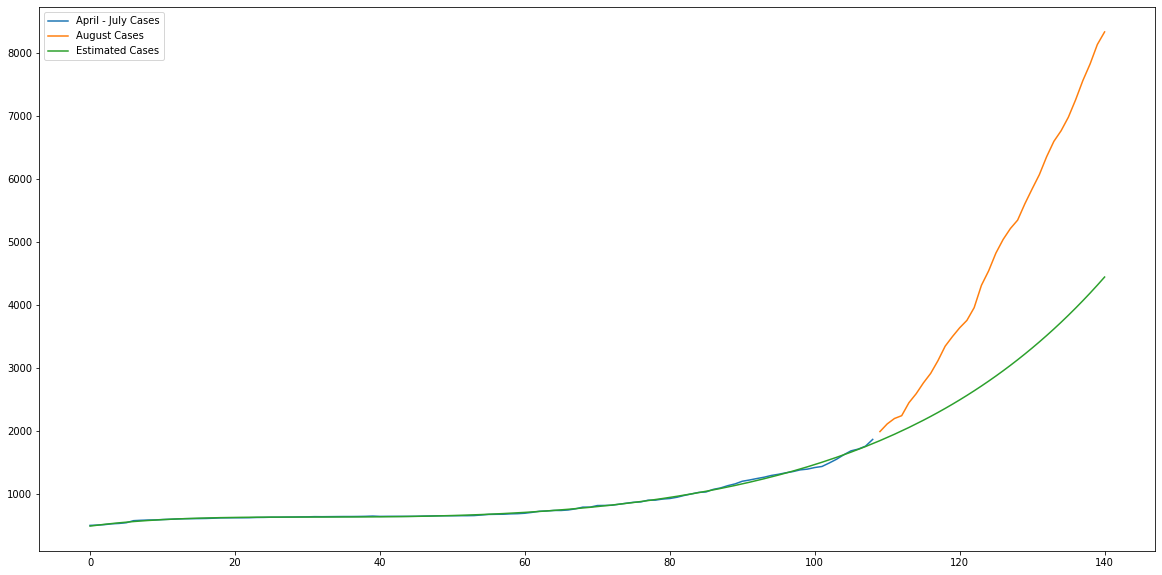

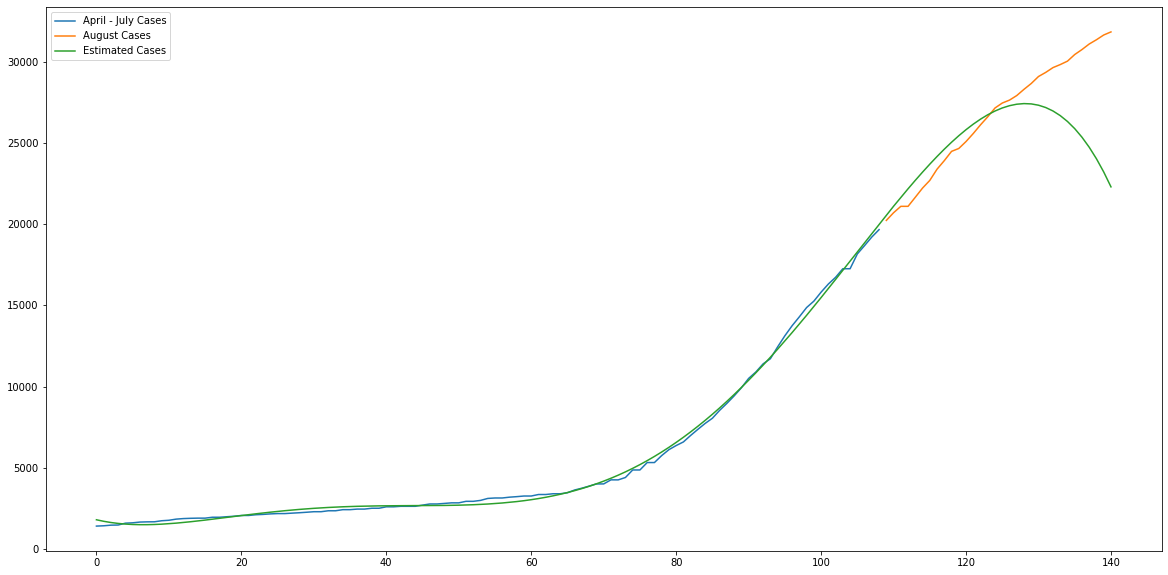

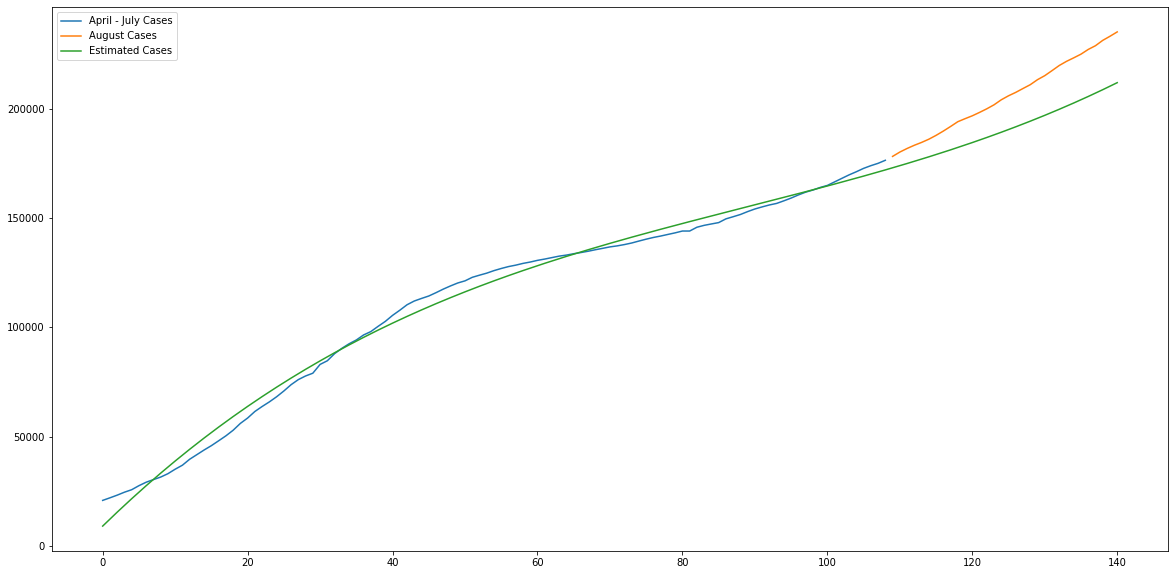

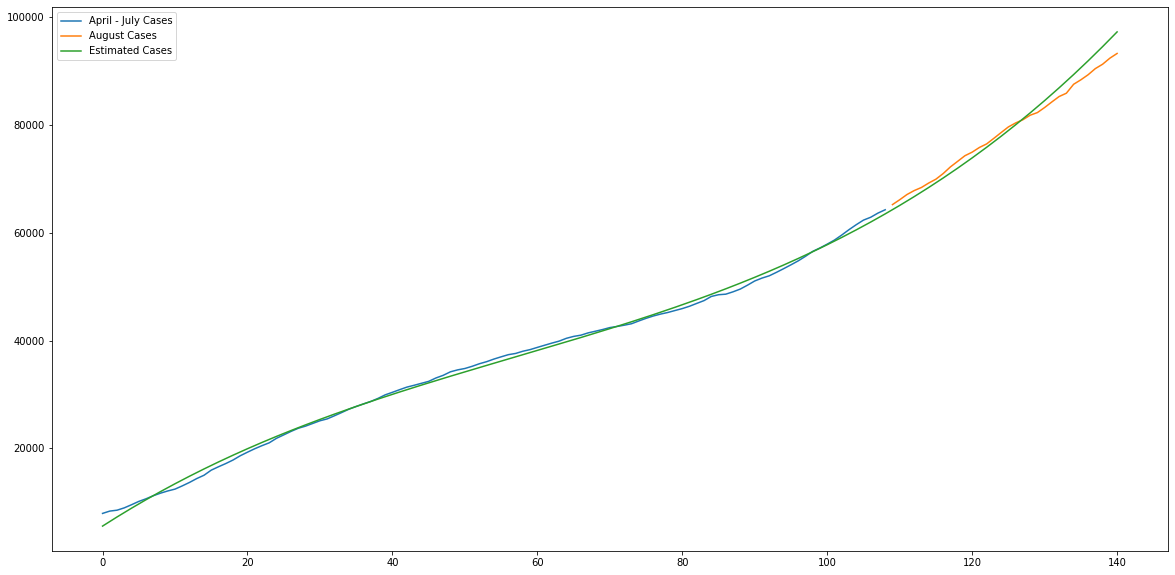

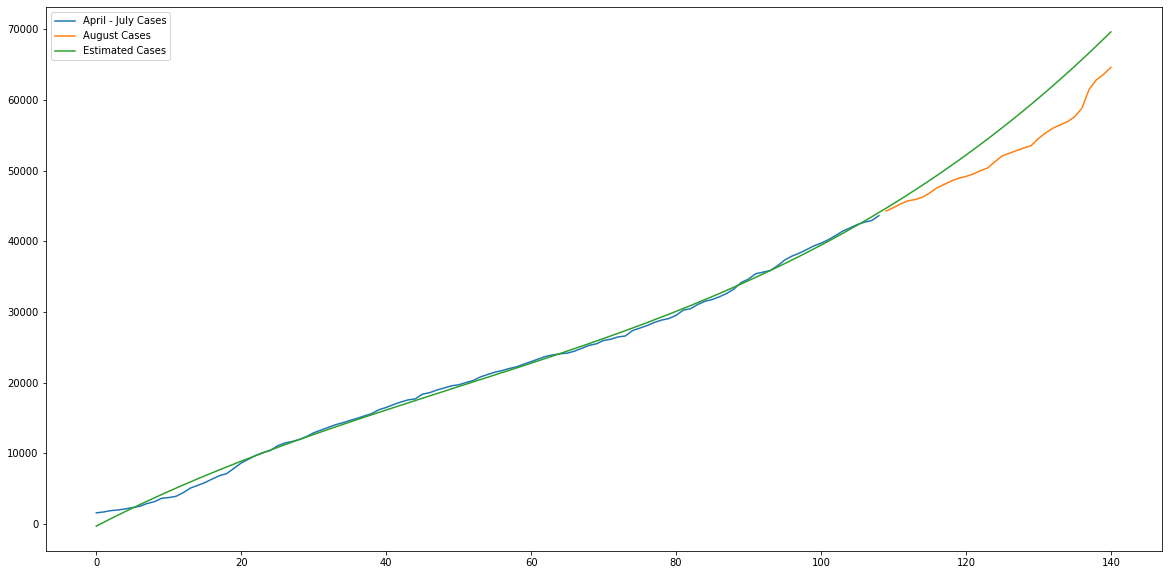

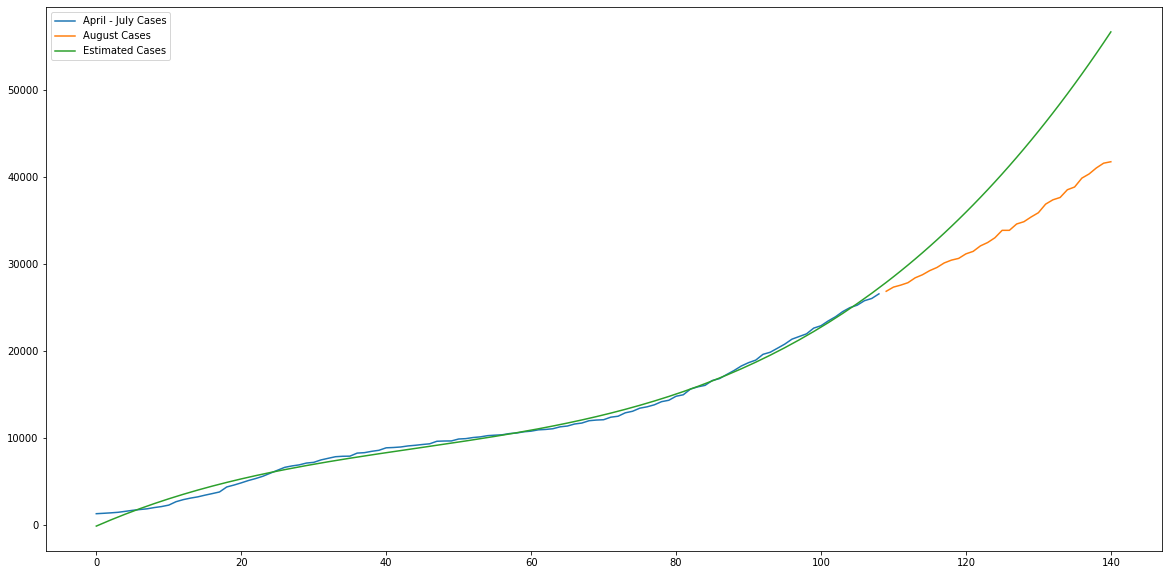

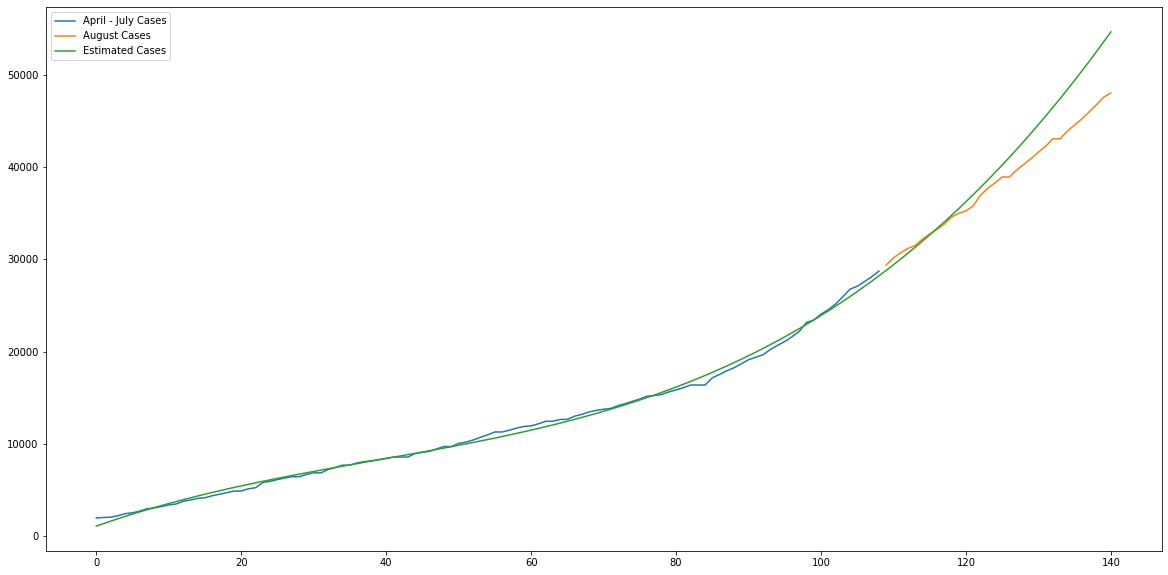

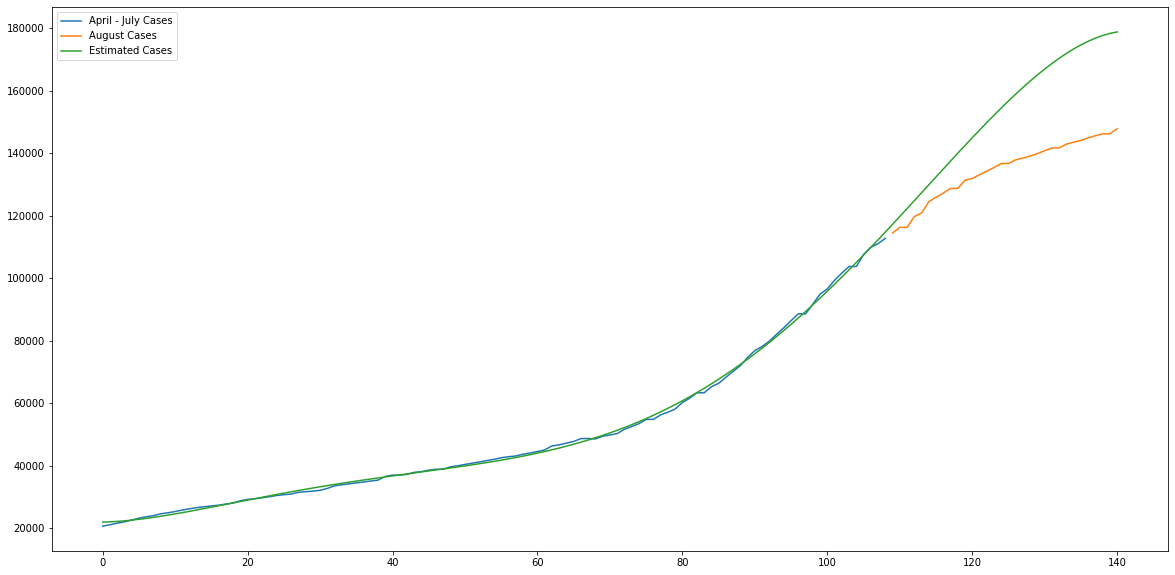

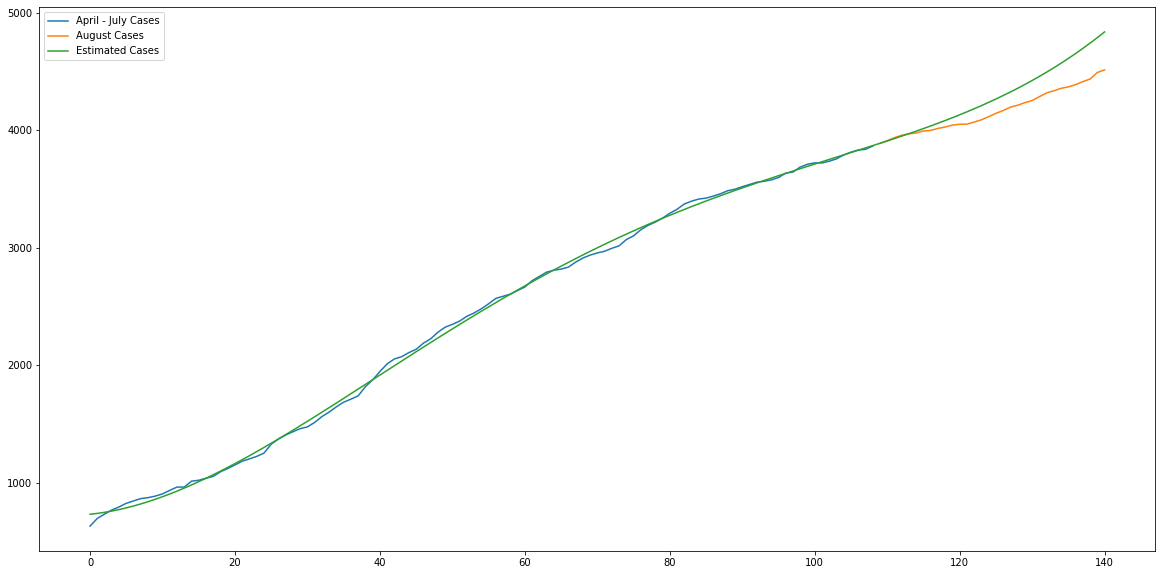

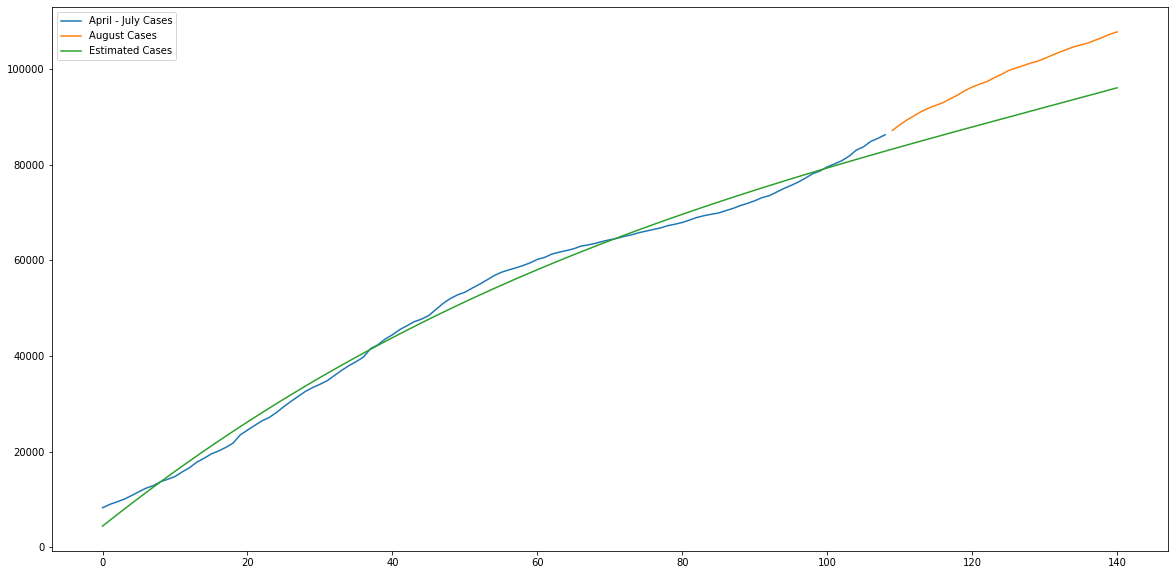

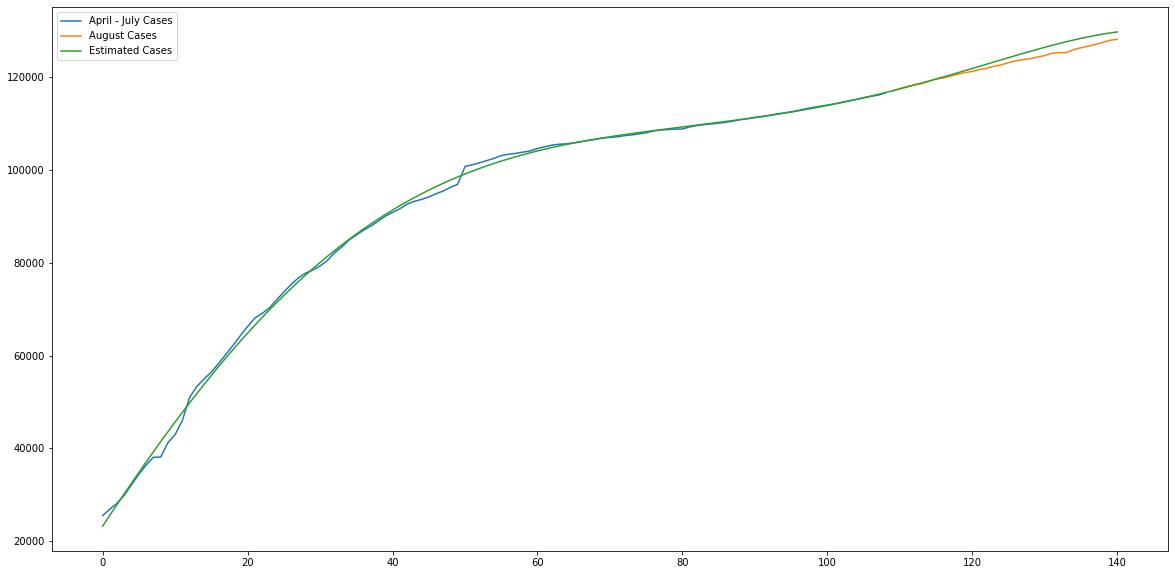

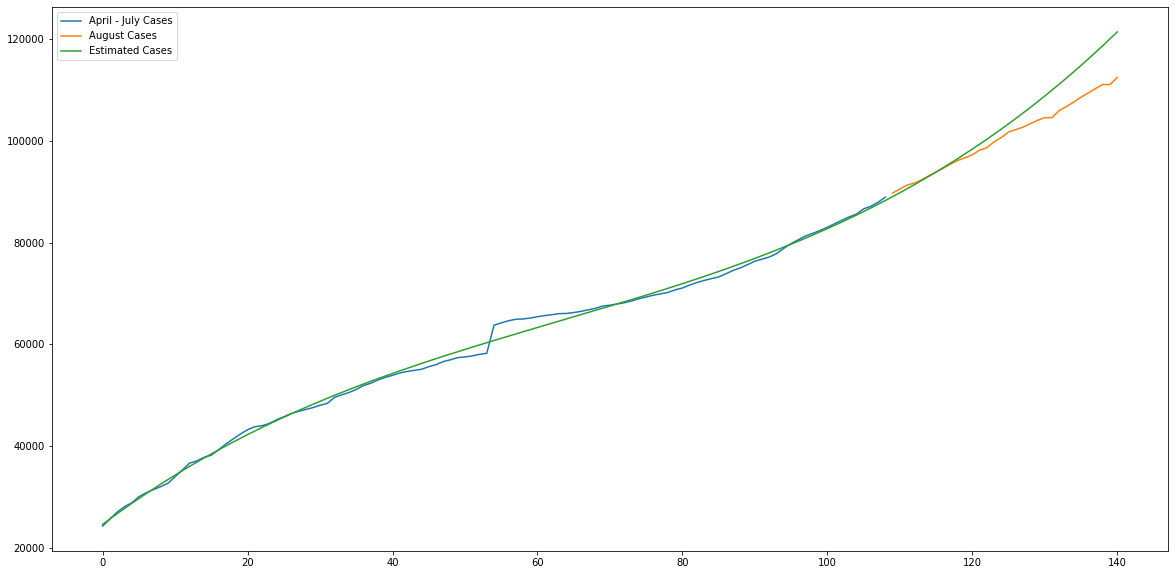

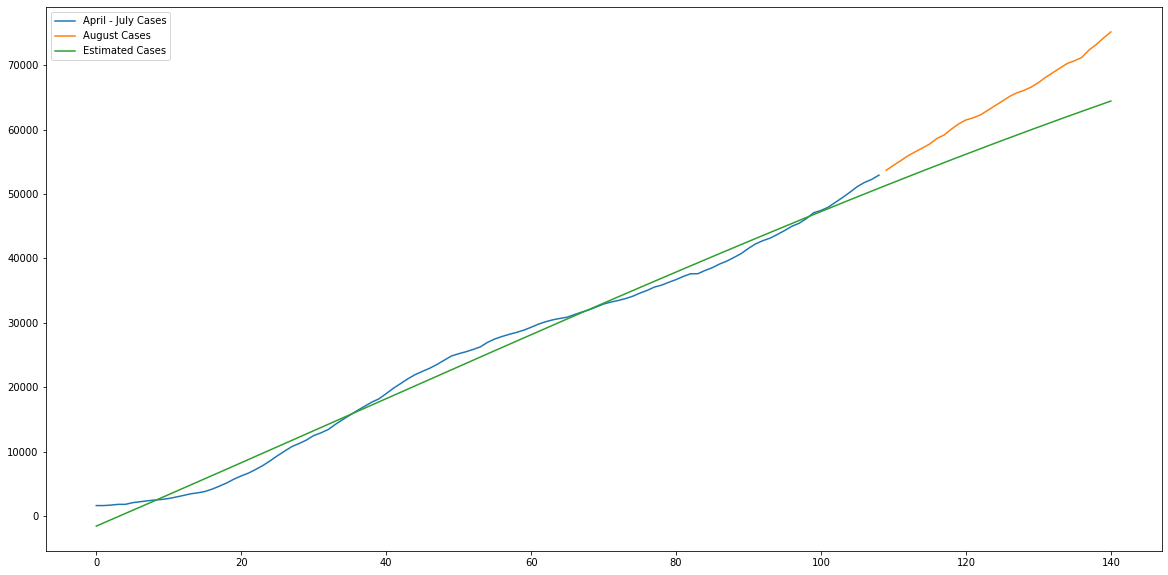

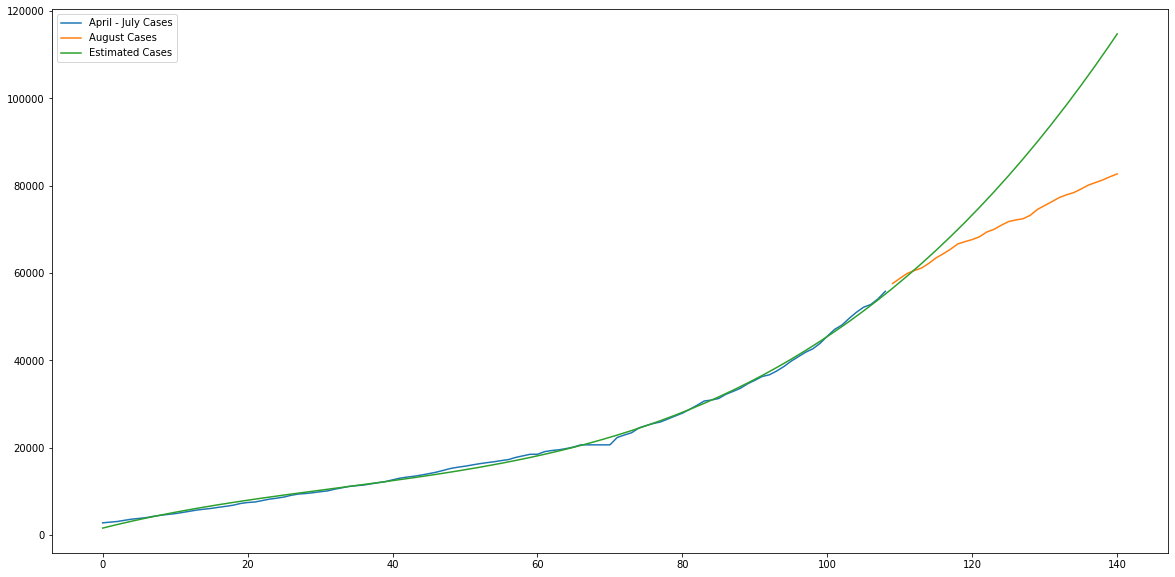

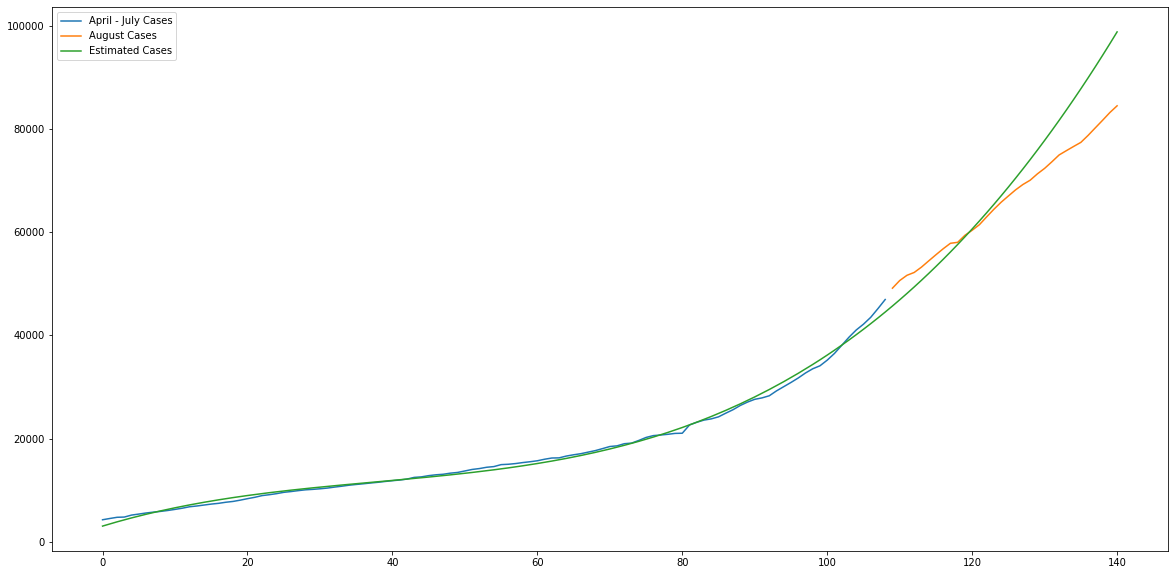

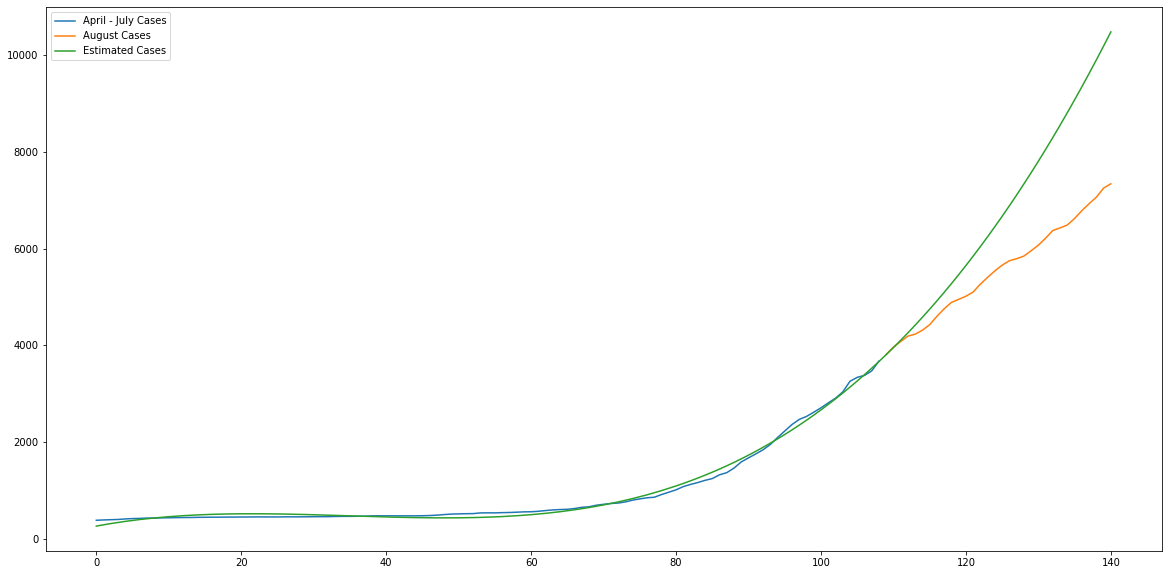

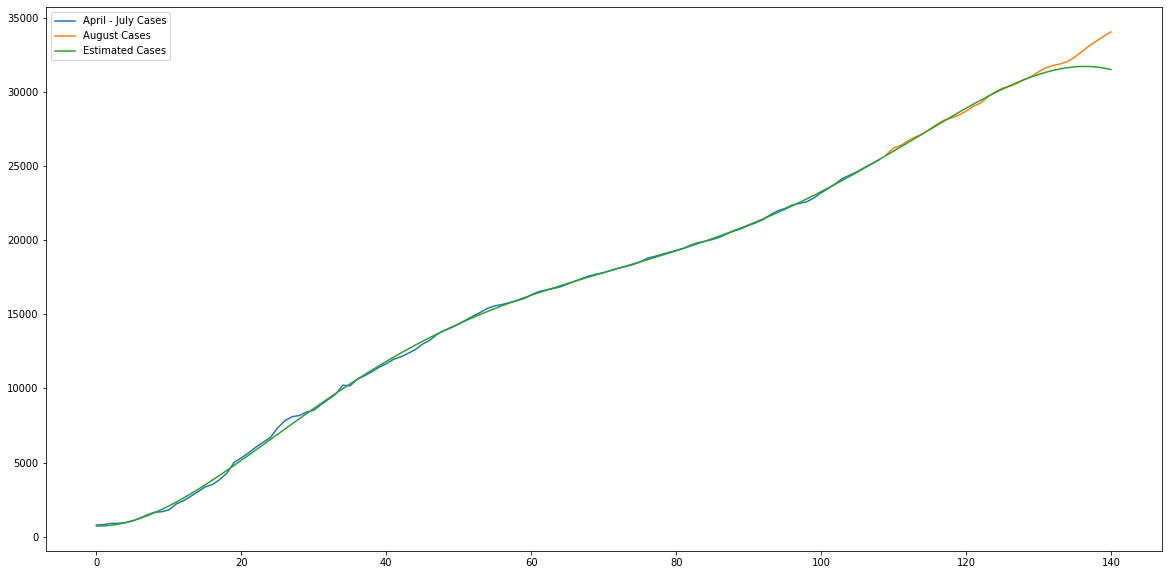

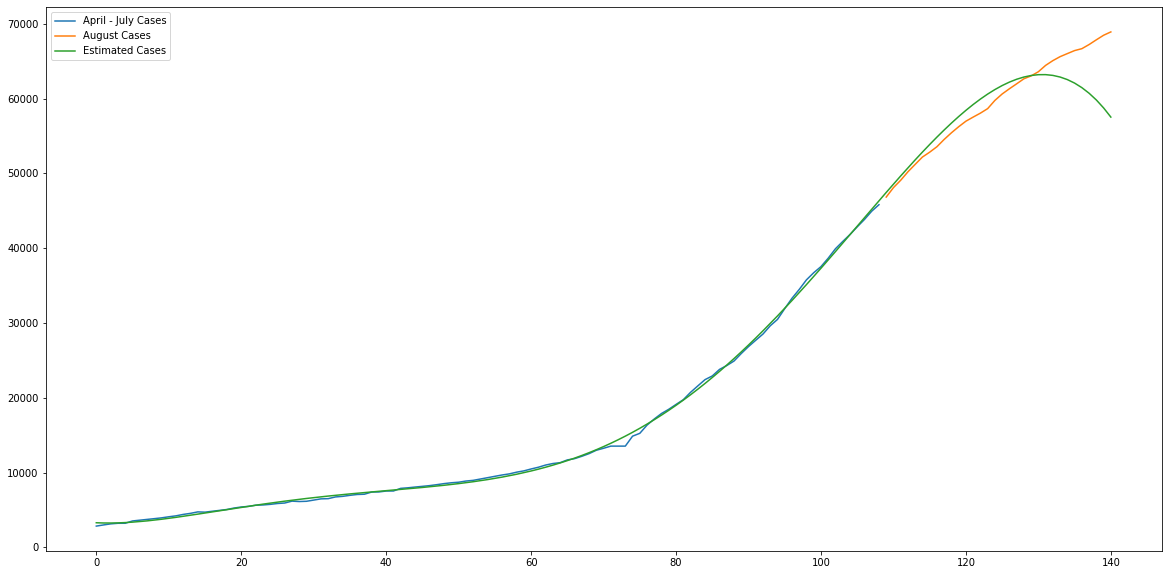

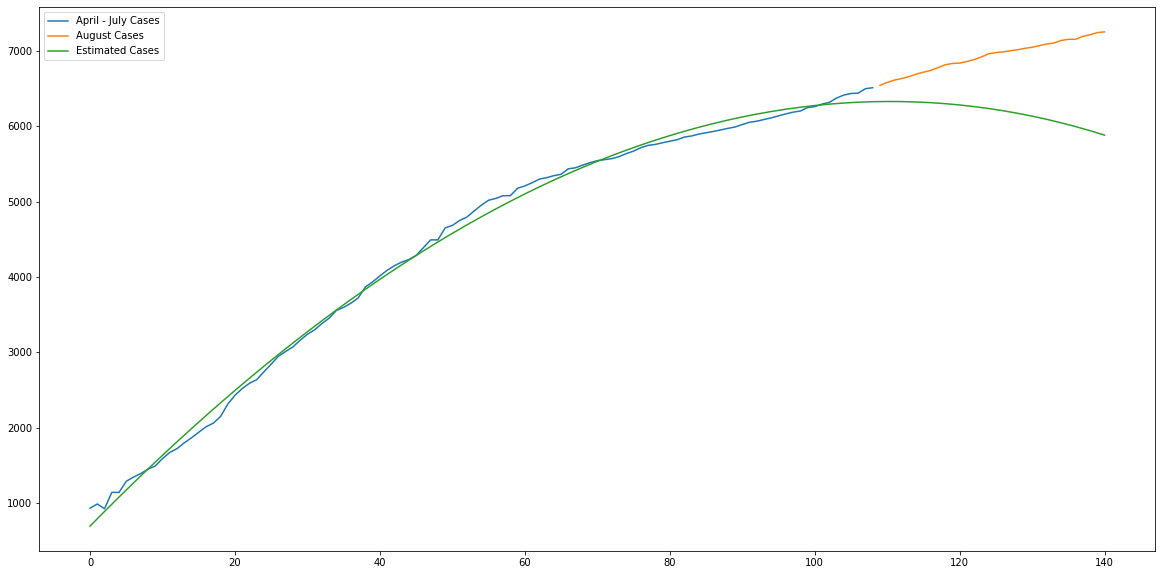

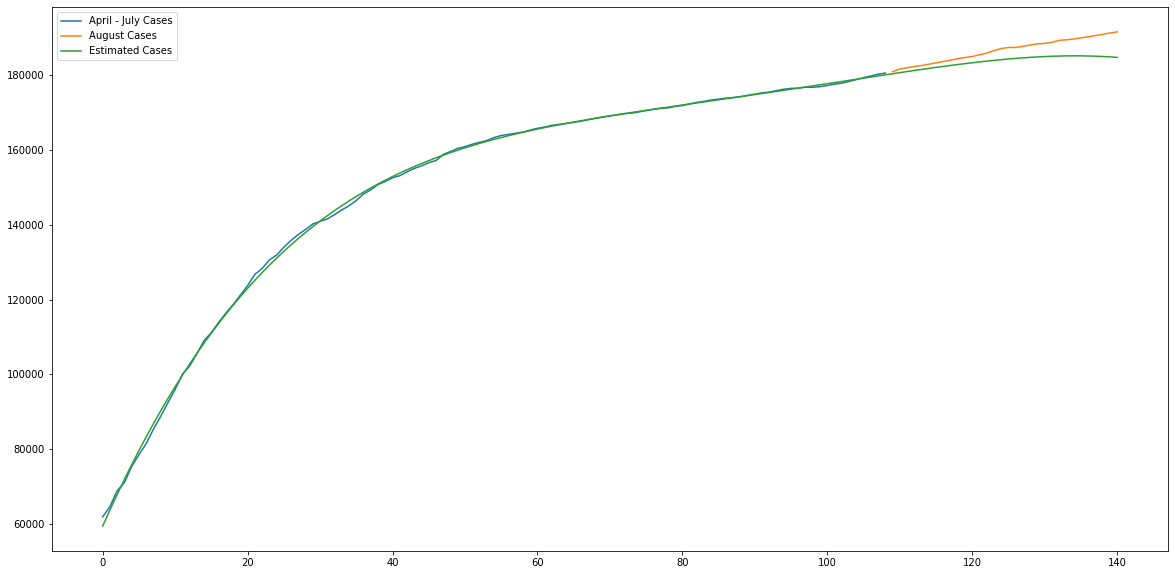

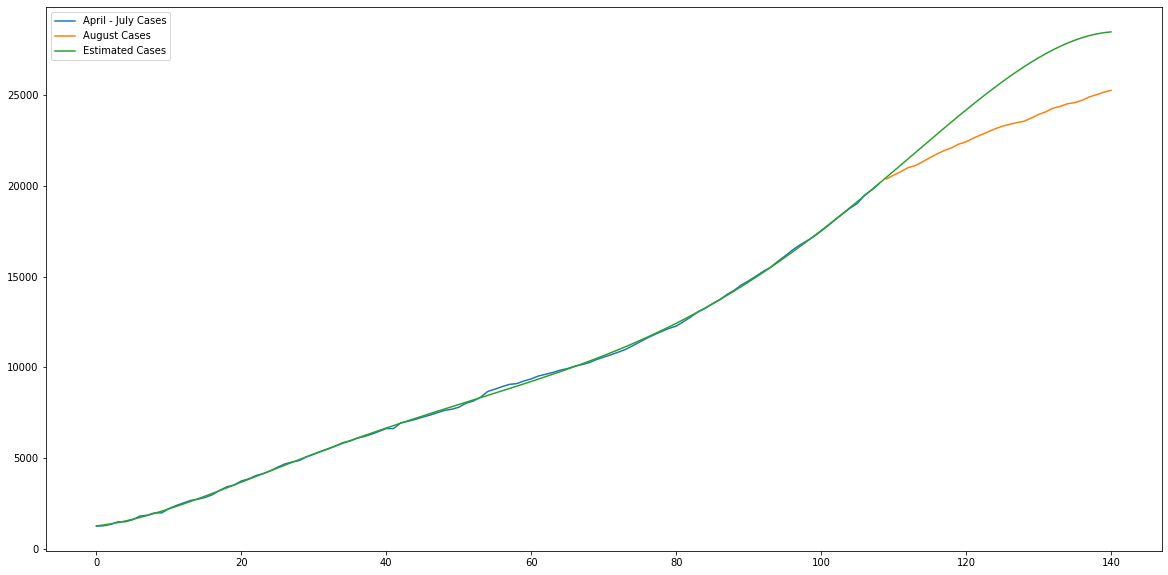

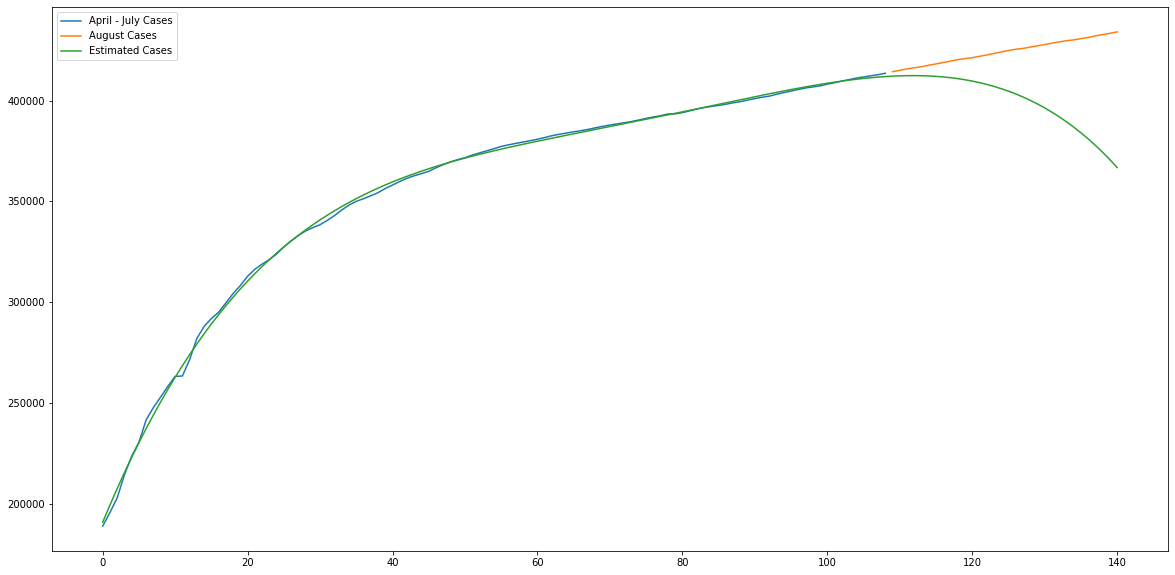

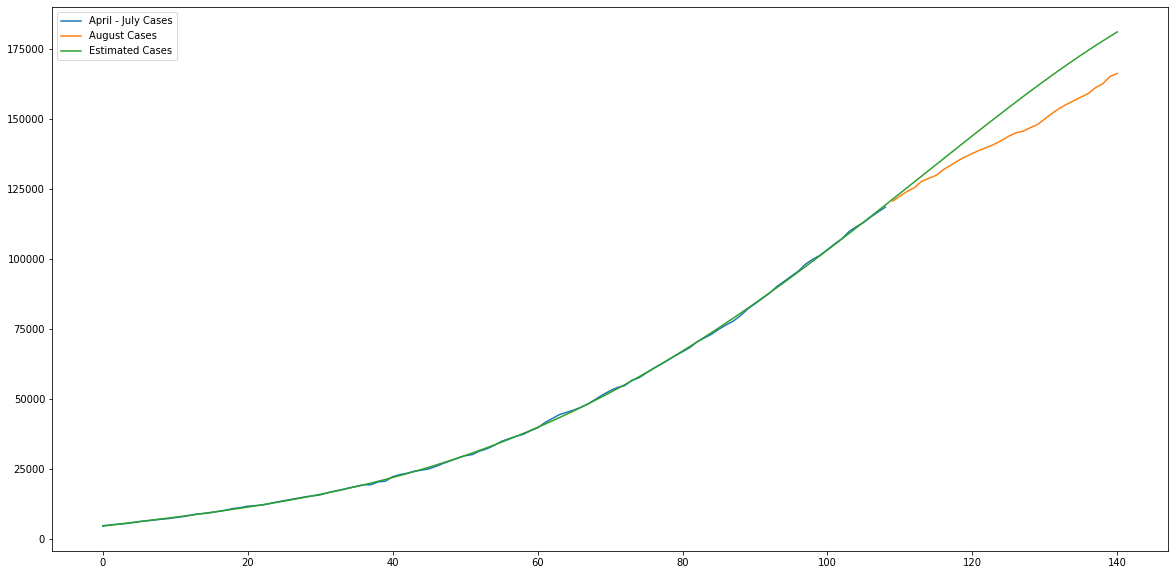

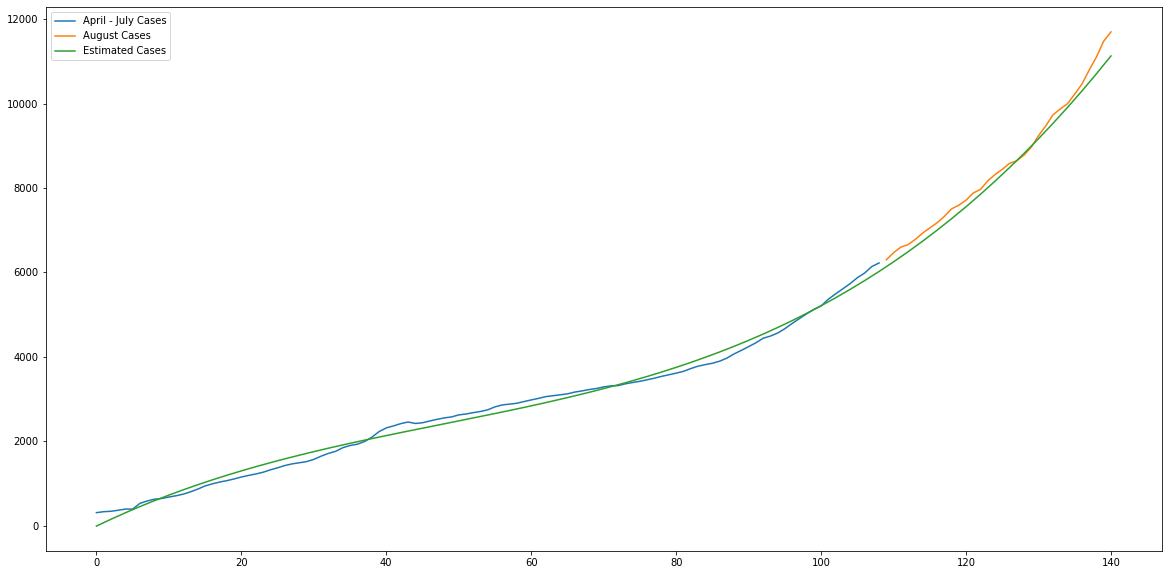

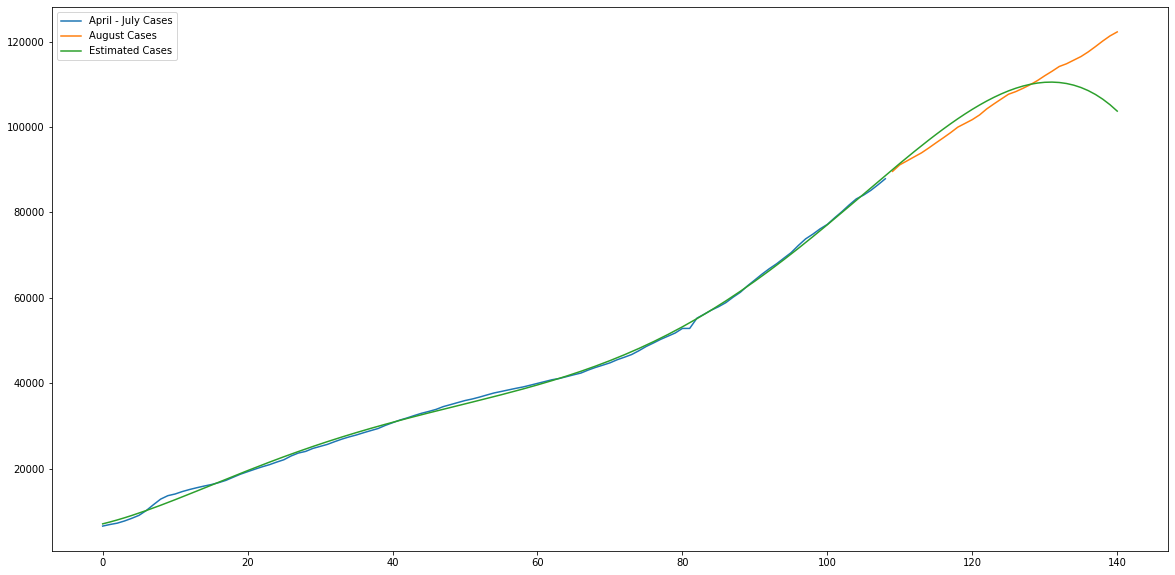

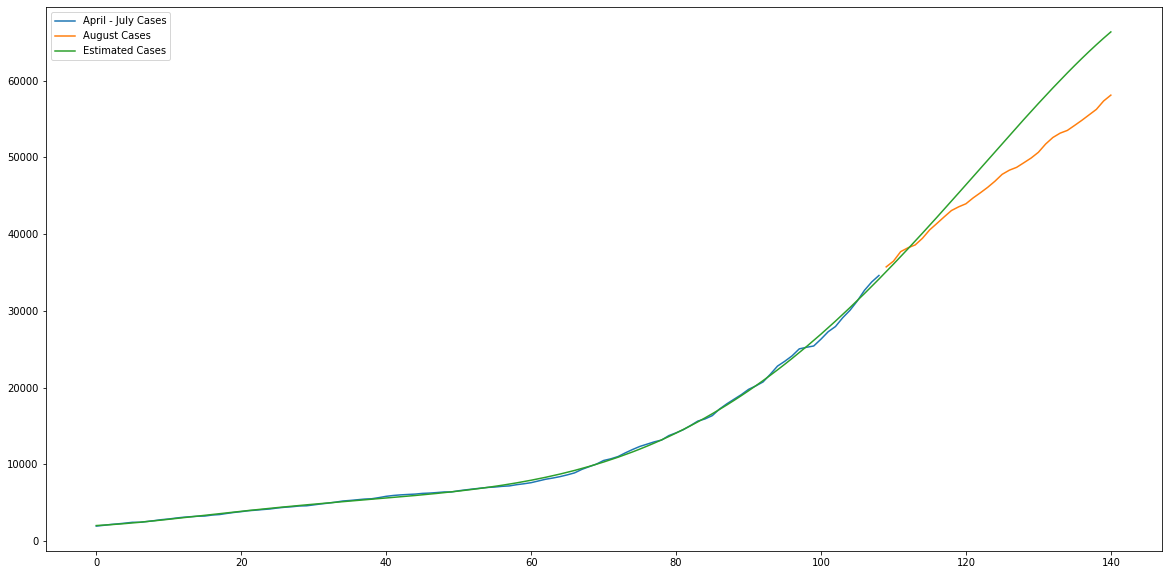

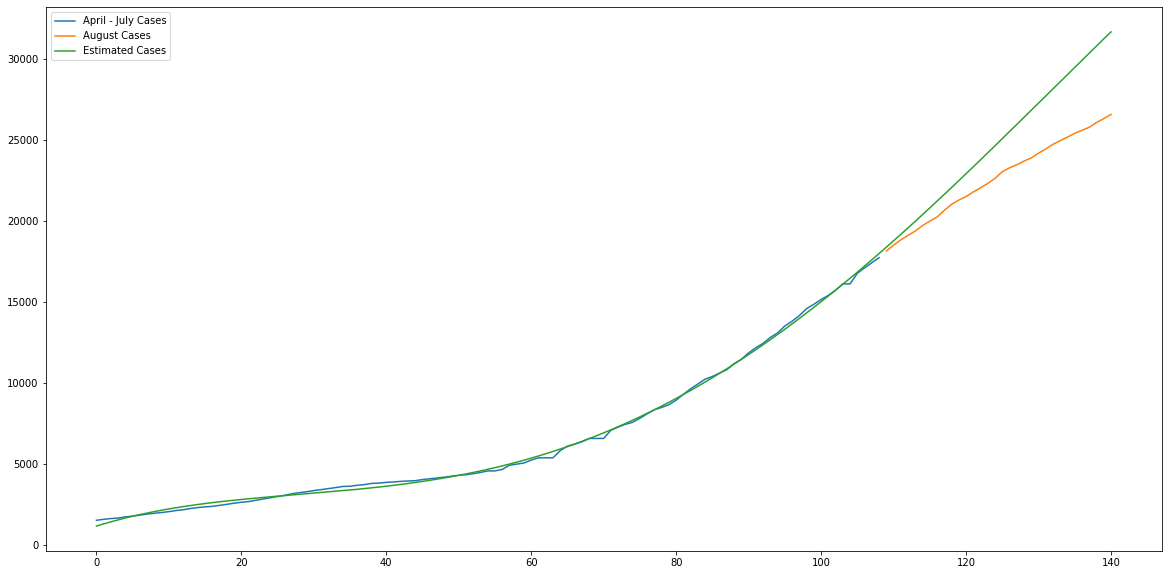

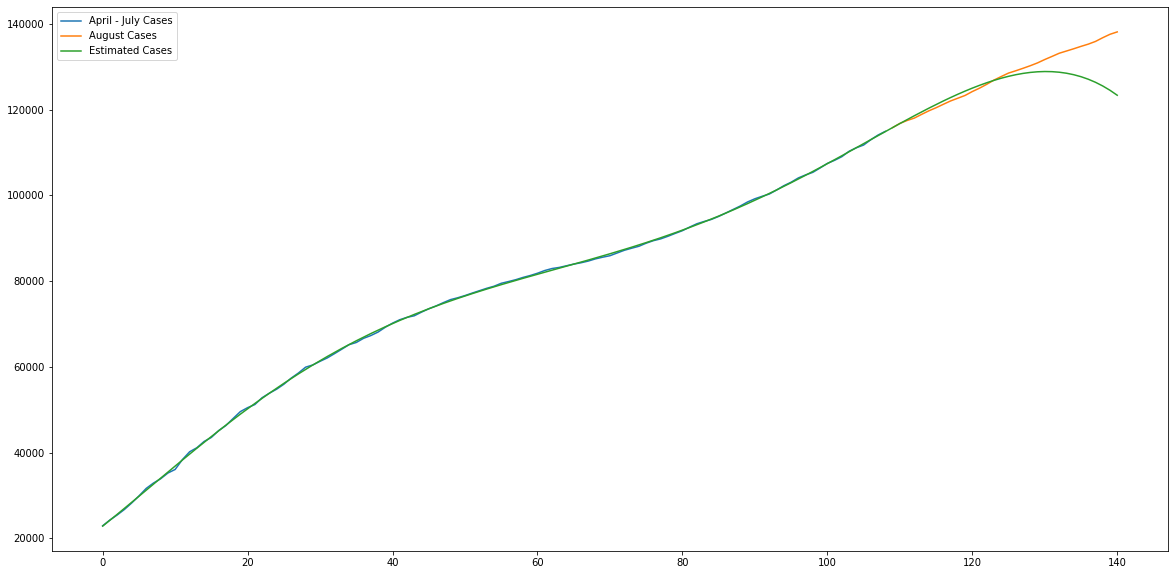

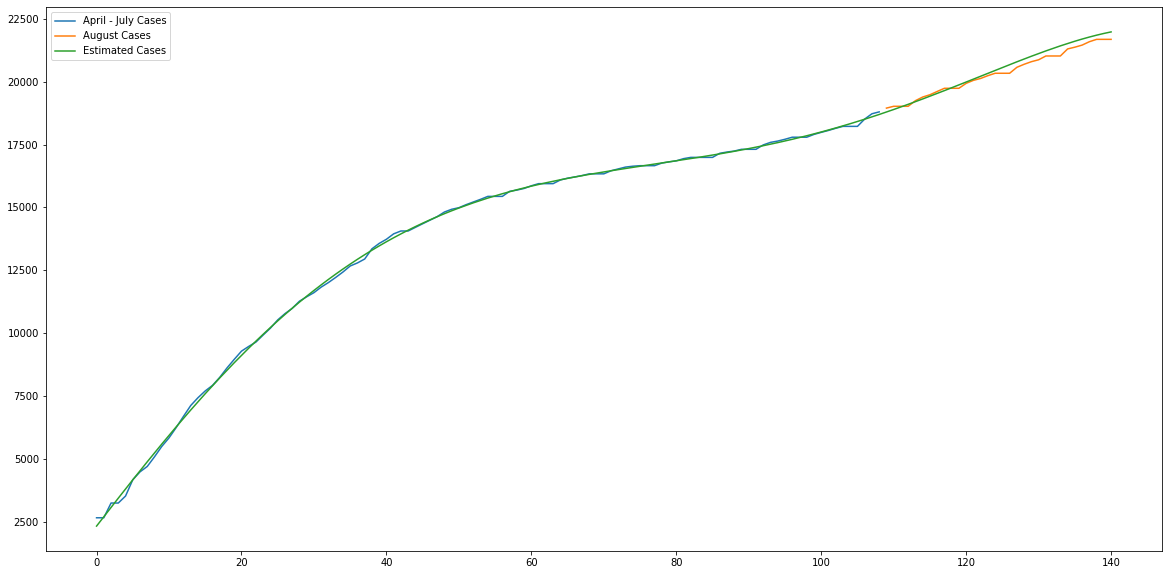

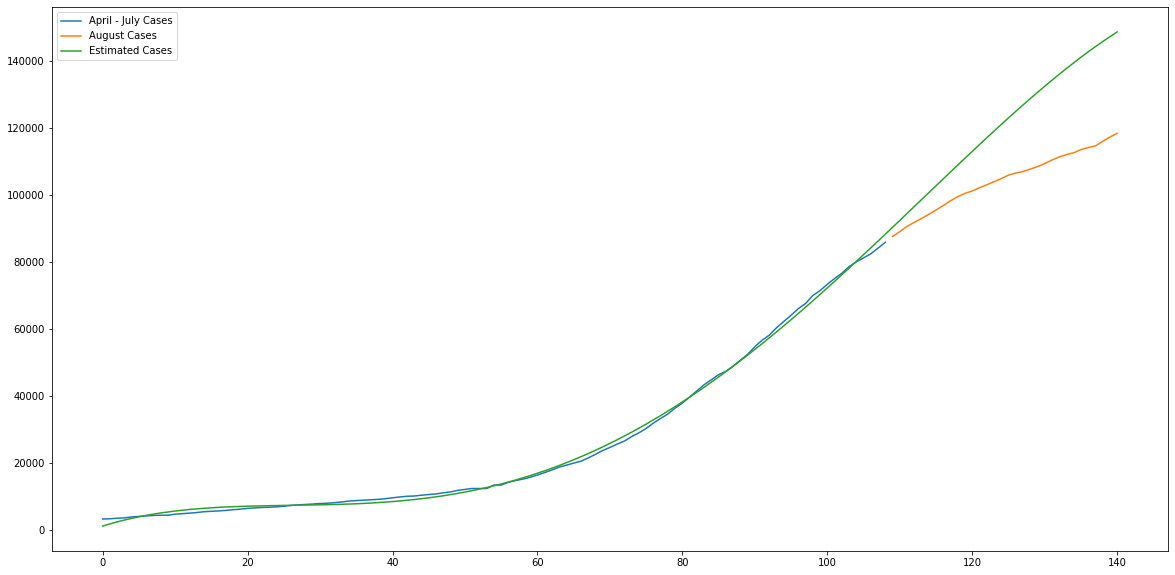

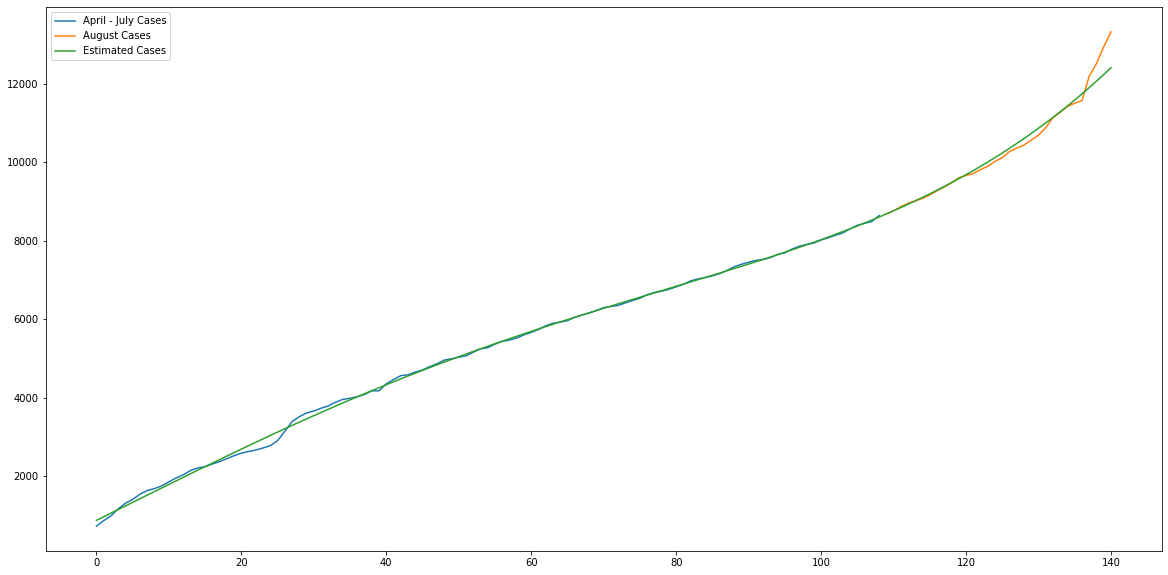

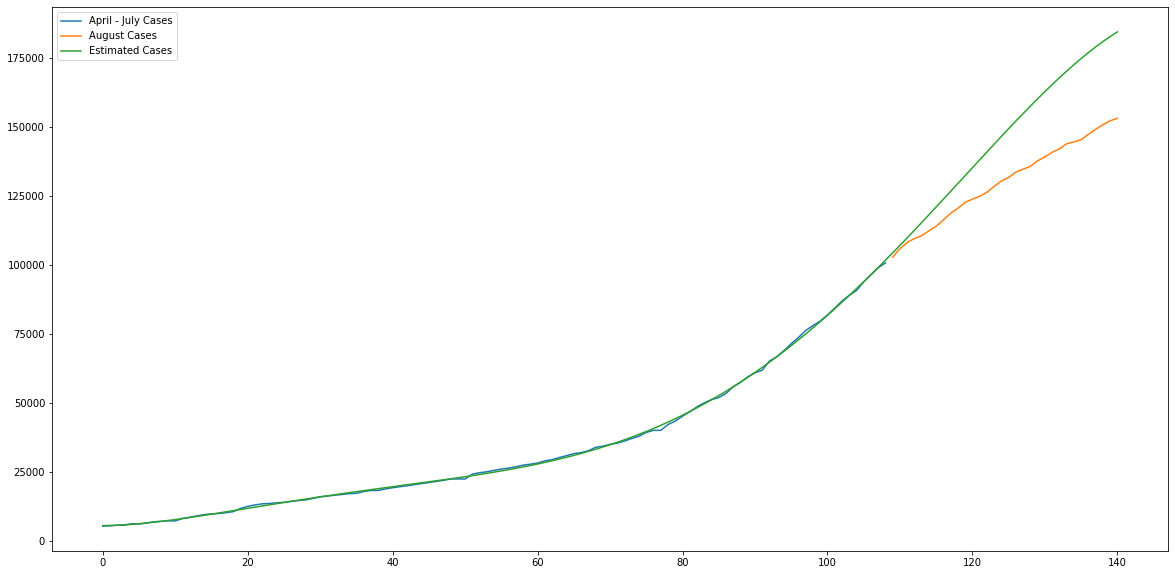

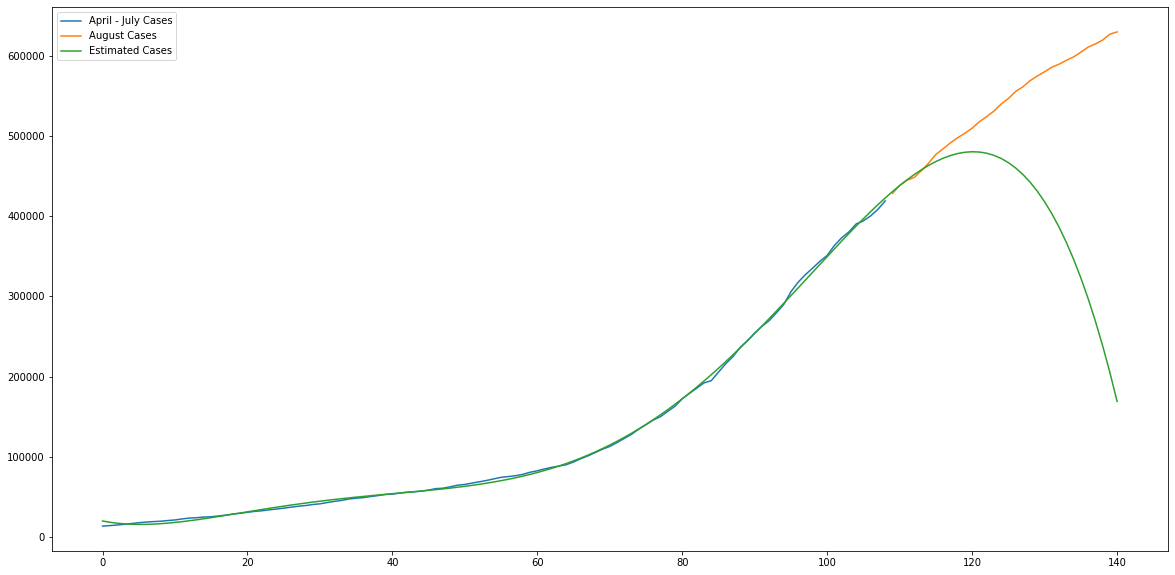

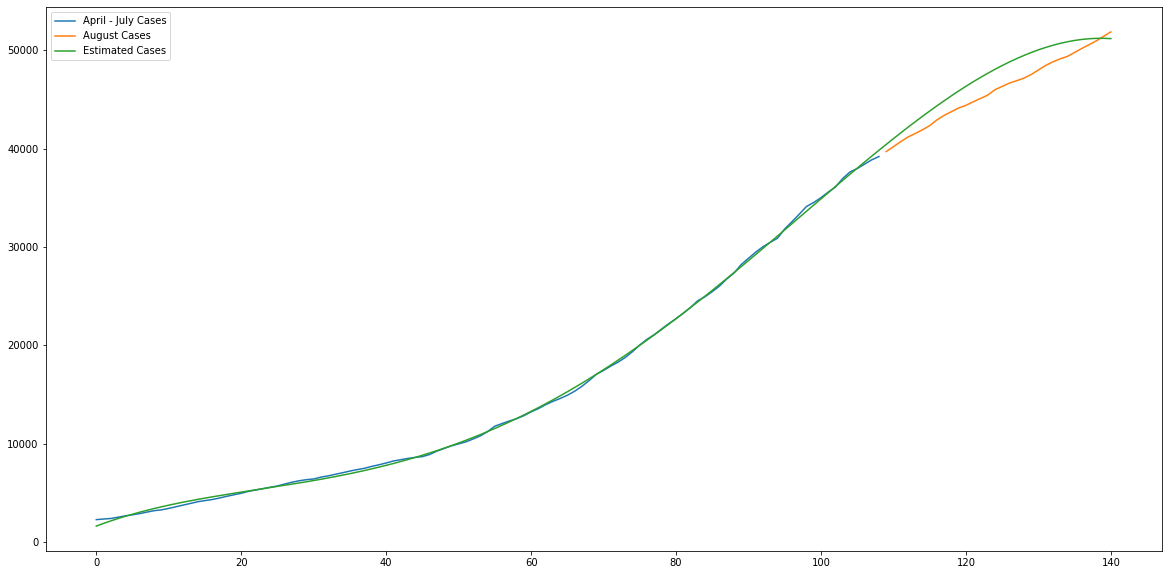

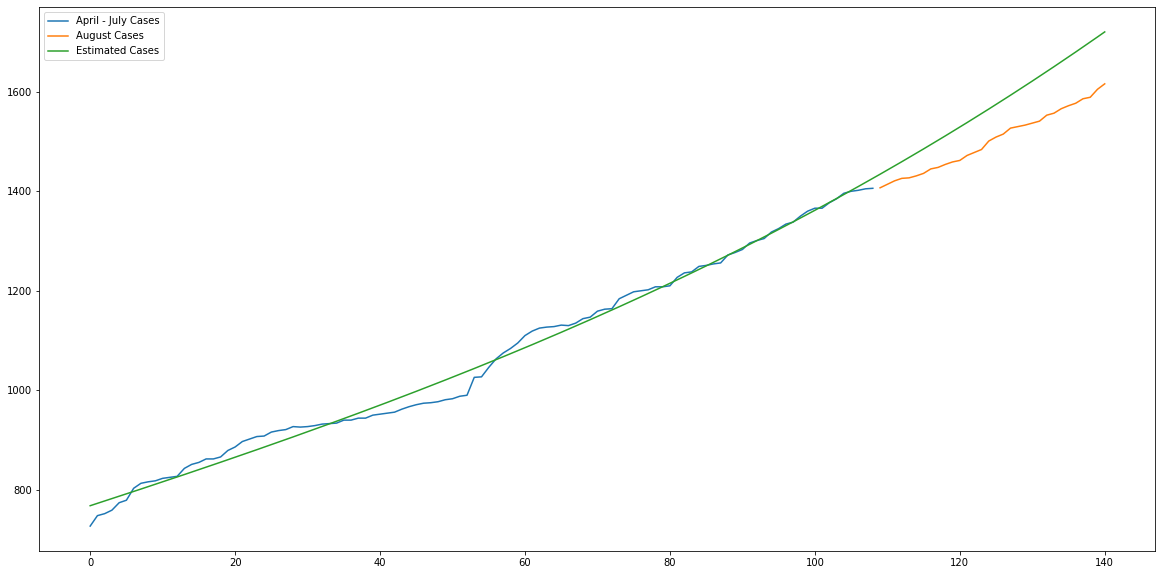

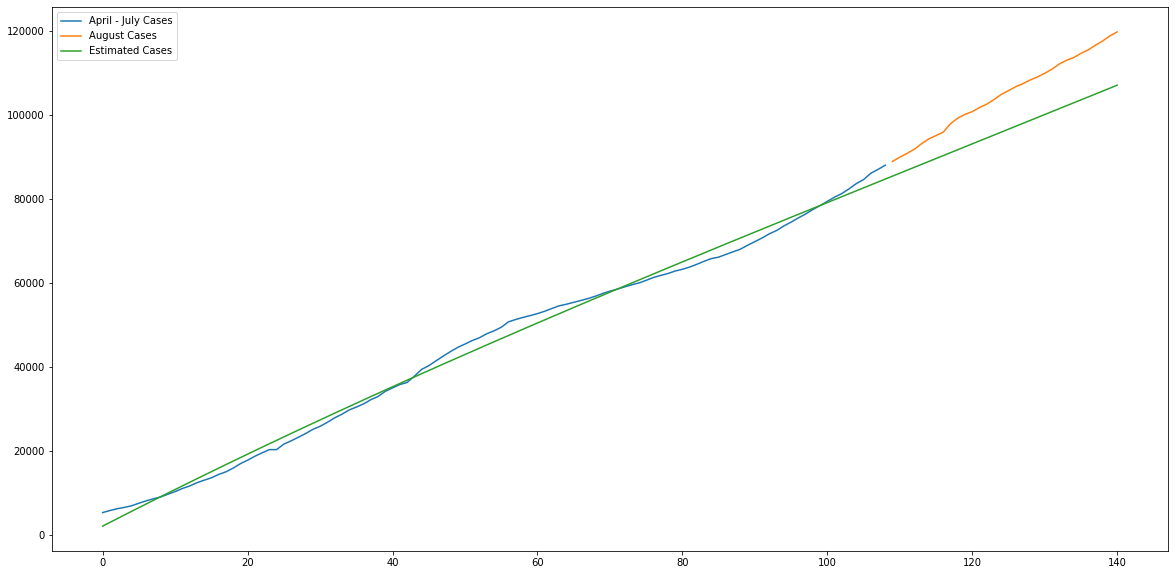

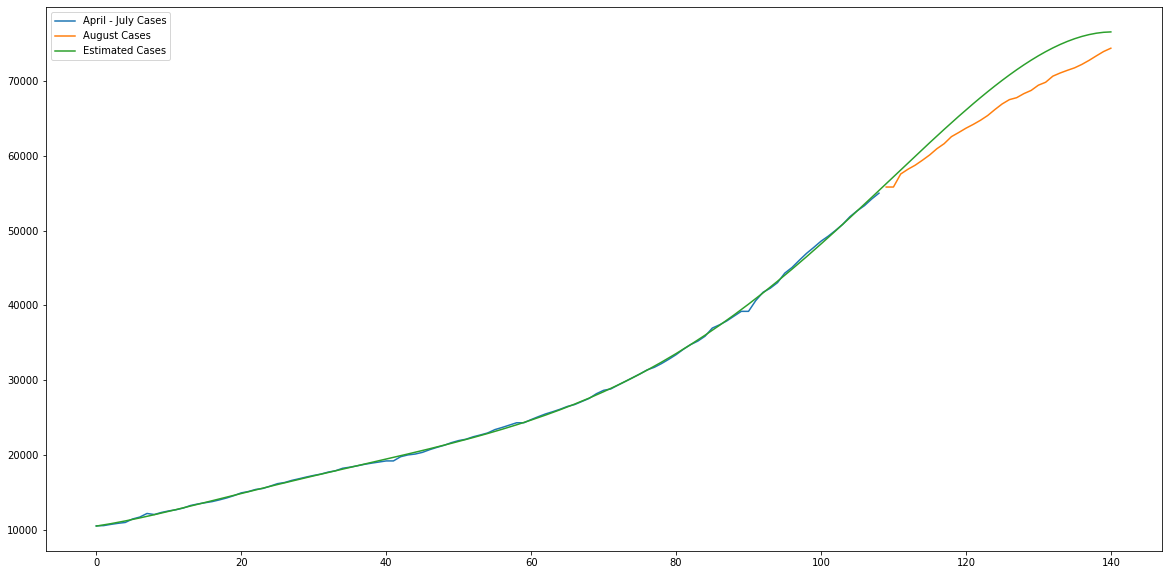

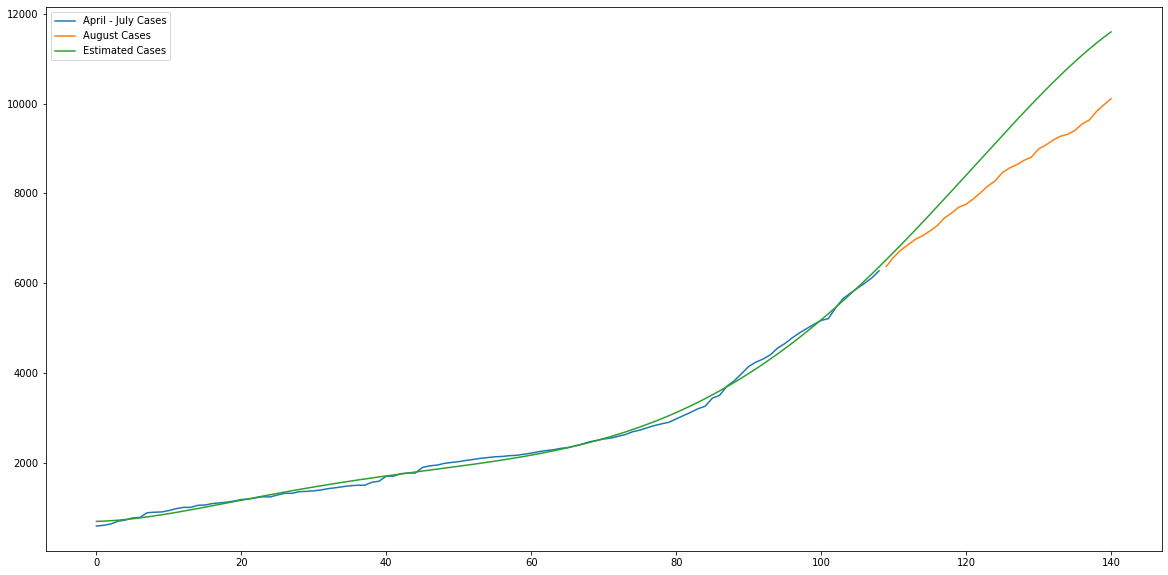

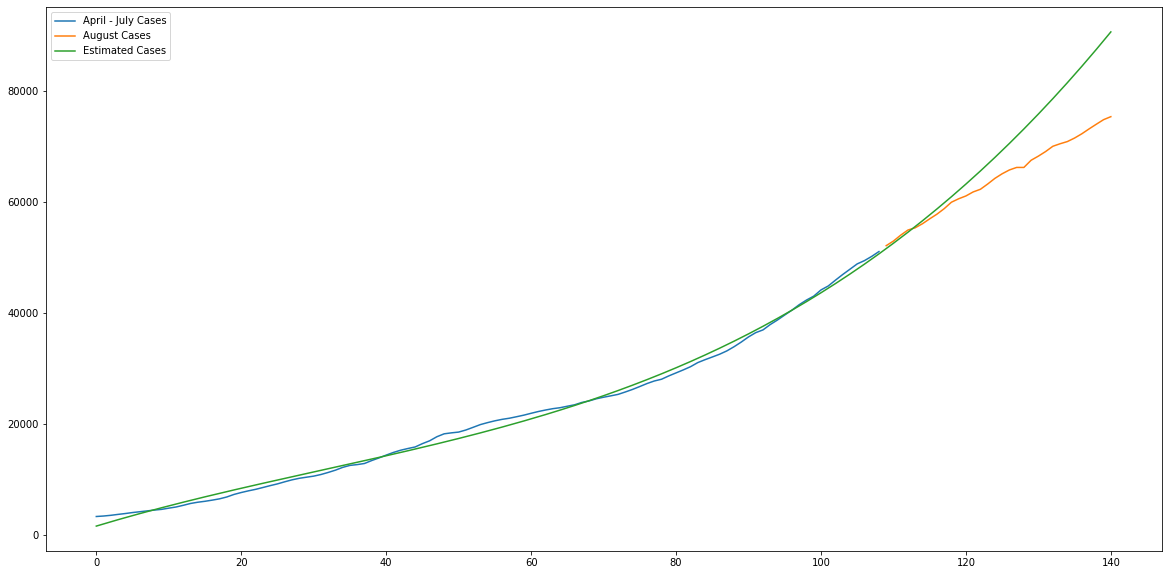

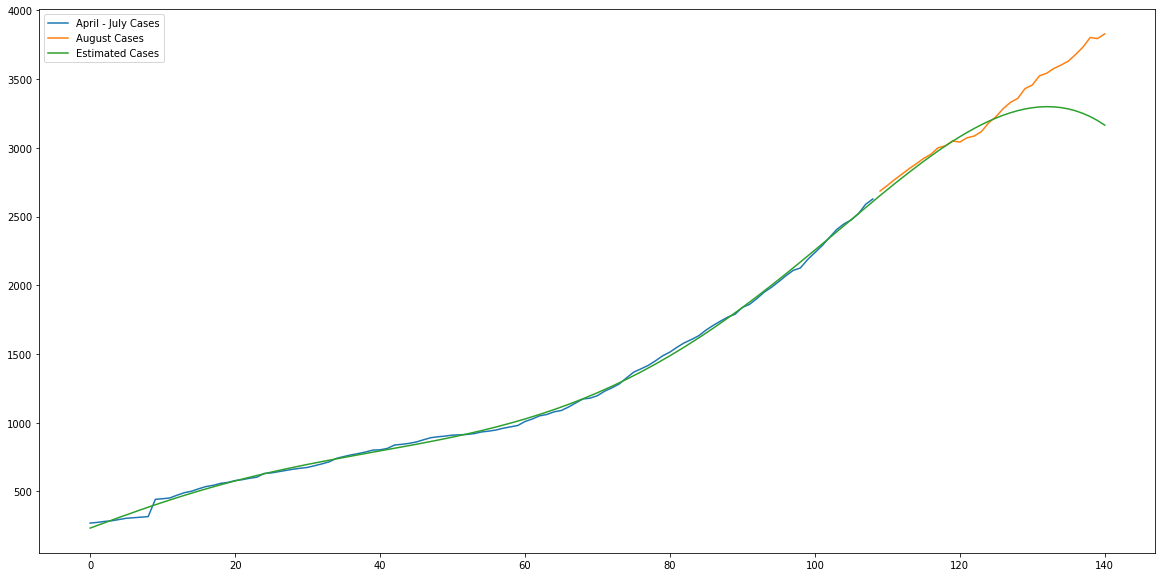

In [ ]:
""" 
Basic Plan for Polynomial Regression
- For each State:
  - Split the train to April - July and August
  - use polynomial regression (degree 3 - 10)
  - use that to find MAPE between August pred. and August Truth
  - use the polynomial regression degree with the lowest MAPE
"""

def best_models_dict_creator(col_to_est: str, graph_on: bool = False) -> dict: 
  best_models_list = {}
  for state in train['Province_State'].unique():
    train_state = train.loc[(train.Last_Update.astype('datetime64[ns]') <= '2020-07-31') & (train['Province_State'] == state), col_to_est].to_numpy()
    val_state = train.loc[(train.Last_Update.astype('datetime64[ns]') > '2020-07-31') & (train['Province_State'] == state), col_to_est].to_numpy()
    x_1 = np.arange(len(train_state))
    x_2 = np.arange(len(val_state)) + len(train_state)

    best_model = (None, 100)
    # checking which polynomial degree has lowest MAPE
    for i in range(3, 6):
      fitted = np.poly1d(np.polyfit(x_1, train_state, i)) 
      mape = calculate_MAPE(fitted(x_2), val_state)
      if best_model[1] > mape:
        best_model = (fitted, mape)

    best_models_list[state] = best_model

    if graph_on:
      plt.figure(figsize=(20,10))
      plt.plot(x_1, train_state, label="April - July Cases")
      plt.plot(x_2, val_state, label = "August Cases")
      plt.plot(np.concatenate((x_1, x_2)), best_model[0](np.concatenate((x_1, x_2))), label = "Estimated Cases")
      plt.legend()
      plt.show()
  return best_models_list

deaths_estimator = best_models_dict_creator('Deaths', False)
confirmed_estimator = best_models_dict_creator('Confirmed', True)


In [ ]:
# Now using the dict that we made earlier to do predictions
result_confirmed = np.zeros(1300)
result_deaths = np.zeros(1300)
for i, state in enumerate(train['Province_State'].unique()):
  truth_train = train.loc[train['Province_State'] == state, 'Confirmed'].to_numpy()
  x_1 = np.arange(len(truth_train))
  truth_test = test.loc[train['Province_State'] == state, 'Confirmed'].to_numpy()
  x_2 = np.arange(len(truth_test)) + len(truth_train)
  
  # plt.figure(figsize=(20,10))
  # plt.plot(x_1, truth_train)
  # plt.plot(x_2, truth_test)
  # plt.plot(np.concatenate((x_1, x_2)), best_models_list['California'][0](np.concatenate((x_1, x_2))))
  # plt.show()

  confirmed = confirmed_estimator[state][0](x_2)
  deaths = deaths_estimator[state][0](x_2)
  for j in range(26):
    result_confirmed[i + (j * 50)] = confirmed[j]
    result_deaths[i + (j * 50)] = deaths[j]
  
print(result_confirmed)
submit_csv.drop(columns=['Confirmed', 'Deaths', 'Province_State', 'Date'], inplace=True)
submit_csv['Confirmed'] = pd.Series(result_confirmed)
submit_csv['Deaths'] = pd.Series(result_deaths)

[164350.61975626   7026.1676461  152428.29219788 ...  10358.9977943
 140806.98000488   -478.89248099]


In [ ]:
submit_csv

,ForecastID,Confirmed,Deaths
0,0,164350.619756,2640.038670
1,1,7026.167646,37.663870
2,2,152428.292198,7555.268284
3,3,58165.353053,697.721944
4,4,538791.533439,13418.427287
...,...,...,...
1295,1295,125663.049943,2450.303748
1296,1296,39942.572231,2532.404855
1297,1297,10358.997794,612.090010
1298,1298,140806.980005,1772.546447


In [ ]:
submit_csv.to_csv('/content/gdrive/MyDrive/COVID19_project/Team1_polynomial_regression.csv', index=False)